In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join
import os
import sys
sys.path.append("/n/home12/binxuwang/Github/Closed-loop-visual-insilico")
import timm
import torch
import torch as th
import torch.nn as nn
from tqdm.auto import tqdm
from os.path import join
import pickle as pkl
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from horama import maco, plot_maco
from torch.utils.data import DataLoader
from torchvision.models import resnet50
from torchvision.models.feature_extraction import create_feature_extractor
import torchvision.transforms as T
from torchvision.transforms import ToPILImage, ToTensor, Normalize, Resize
from circuit_toolkit.CNN_scorers import TorchScorer
from circuit_toolkit.GAN_utils import upconvGAN, Caffenet
from circuit_toolkit.plot_utils import to_imgrid, show_imgrid, save_imgrid, saveallforms
from circuit_toolkit.layer_hook_utils import featureFetcher_module, featureFetcher, get_module_names
from circuit_toolkit.dataset_utils import ImagePathDataset
from neural_regress.regress_lib import sweep_regressors, perform_regression_sweeplayer_RidgeCV, perform_regression_sweeplayer, record_features
from neural_regress.sklearn_torchify_lib import SRP_torch, PCA_torch, LinearRegression_torch, SpatialAvg_torch, LinearLayer_from_sklearn
from core.data_utils import load_neural_data, load_from_hdf5, load_neural_trial_resp_tensor, create_response_tensor, parse_image_fullpaths
from core.model_load_utils import load_model_transform

In [3]:
import xarray as xr

In [4]:
subject_id1 = "red_20241212-20241220"
subject_id3 = "red_20250123-20250126"

In [5]:
encoding_root = r"/n/holylabs/LABS/alvarez_lab/Lab/VVS_Accentuation/Encoding_model_outputs"
encoding_dir = join(encoding_root, "red_20241212-20241220")
ds1 = xr.open_dataset(join(encoding_dir, f"population_resp_pred_{subject_id1}_RN50_RN50rbst_L4B1_Lasso_Ridge.nc"))
ds3 = xr.open_dataset(join(encoding_dir, f"population_resp_pred_{subject_id3}_RN50_RN50rbst_L4B1_Lasso_Ridge.nc"))

In [6]:
stimulus_d3 = pd.DataFrame(ds3.stimulus.values, columns=['stimulus'])

In [7]:
# Extract information using regex for all stimuli
import re
import pandas as pd

pattern = r'(?P<model>resnet50|robust_resnet50)_(?P<method>MultiLassoCV|RidgeCV)_unit_(?P<unit>\d+)_img_(?P<img>\d+)_level_(?P<level>[-\d.]+)_score_(?P<score>[-\d.]+)\.png'
# Initialize empty list to store matches
matches = []
# Go through all stimuli
for stim in stimulus_d3.stimulus.values:
    match = re.match(pattern, stim)
    if match:
        info = match.groupdict()
        info["stimulus"] = stim
        info["accentuated"] = True
        matches.append(info)
    else:
        # For non-matching stimuli (like NSD), add None values
        matches.append({
            "stimulus": stim,
            "accentuated": False,
            'model': None,
            'method': None, 
            'unit': None,
            'img': None,
            'level': None,
            'score': None
        })

# Convert to DataFrame
stim_meta_df = pd.DataFrame(matches)
# Convert numeric columns
numeric_cols = ['level', 'score']
for col in numeric_cols:
    stim_meta_df[col] = pd.to_numeric(stim_meta_df[col], errors='coerce').astype(float)

# Convert unit and img to int where possible, keeping NaN values
numeric_cols = ['unit', 'img']
for col in numeric_cols:
    stim_meta_df[col] = pd.to_numeric(stim_meta_df[col], errors='coerce').astype('Int64') 
print("Extracted information for all stimuli:")
print(stim_meta_df.head())
print(f"\nTotal rows: {len(stim_meta_df)}")
stim_meta_df["is_nsd"] = stimulus_d3['stimulus'].str.contains('nsd')
stim_meta_df["is_controversial"] = stimulus_d3['stimulus'].str.contains('controversial')
# assert that there is no controversial or nsd in the accentuated stimuli
assert stim_meta_df.query('not (accentuated or is_controversial or is_nsd)').empty
stim_meta_df.query("is_controversial").stimulus.unique()
# Pattern to match controversial image filenames
controversial_pattern = r'controversial_max_(?P<model>r50|robust)_(?P<method>MultiLassoCV)_unit_(?P<unit>\d+)_img_(?P<img>\d+)_srobust_(?P<score_robust>[-\d.]+)_sr50_(?P<score_r50>[-\d.]+)\.png'

# Initialize empty list to store matches
controversial_matches = []

# Go through controversial stimuli
controversial_stimuli = stim_meta_df.query("is_controversial").stimulus.values
for stim in controversial_stimuli:
    match = re.match(controversial_pattern, stim)
    if match:
        info = match.groupdict()
        info["stimulus"] = stim
        controversial_matches.append(info)
    else:
        print(f"No match found for controversial stimulus: {stim}")

# Convert to DataFrame
controversial_df = pd.DataFrame(controversial_matches)

# Convert numeric columns
numeric_cols = ['score_robust', 'score_r50',]
for col in numeric_cols:
    controversial_df[col] = pd.to_numeric(controversial_df[col], errors='coerce')
numeric_cols = ['unit', 'img']
for col in numeric_cols:
    controversial_df[col] = pd.to_numeric(controversial_df[col], errors='coerce').astype('Int64')

# Print first few rows to verify parsing
print("Extracted information from controversial stimuli:")
print(controversial_df.head())
print(f"\nTotal controversial stimuli parsed: {len(controversial_df)}")
stim_contrv_meta_df = stim_meta_df.fillna(controversial_df).merge(controversial_df[["stimulus", "score_robust", "score_r50", ]], on="stimulus", how="outer")

Extracted information for all stimuli:
                                            stimulus  accentuated model  \
0  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
1  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
2  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
3  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   
4  controversial_max_r50_MultiLassoCV_unit_15_img...        False  None   

  method  unit   img  level  score  
0   None  <NA>  <NA>    NaN    NaN  
1   None  <NA>  <NA>    NaN    NaN  
2   None  <NA>  <NA>    NaN    NaN  
3   None  <NA>  <NA>    NaN    NaN  
4   None  <NA>  <NA>    NaN    NaN  

Total rows: 3420
Extracted information from controversial stimuli:
  model        method  unit  img  score_robust  score_r50  \
0   r50  MultiLassoCV    15    0     -0.394836  10.820349   
1   r50  MultiLassoCV    15    1     -0.322991  11.145054   
2   r50  MultiLassoCV    15    2     

In [9]:
figroot = join("/n/home12/binxuwang/Github/Closed-loop-visual-insilico/figures", subject_id3)
os.makedirs(figroot, exist_ok=True)

In [10]:
stim_contrv_meta_df.to_pickle(join(figroot, "stim_info_meta_df.pkl"))
stim_contrv_meta_df.to_csv(join(figroot, "stim_info_meta_df.csv"))

### Visualize stimuli

In [11]:
from PIL import Image

In [66]:
def display_stimuli(idxs, cols=None, resolution=(256, 256), ):
    """
    Display multiple stimuli as a montage
    
    Parameters:
    -----------
    idxs : list or array-like
        Indices of images to display
    cols : int, optional
        Number of columns in the montage. If None, will try to make a square grid
    figsize : tuple, optional
        Figure size for the montage
    resolution : tuple, optional
        Resolution to resize each image to (width, height)
    """
    if isinstance(idxs, int):
        idxs = [idxs]
    else:   
        idxs = list(idxs)  # Convert to list if it's not already
    n_images = len(idxs)
    
    if n_images == 0:
        return
    
    if cols is None:
        cols = int(np.ceil(np.sqrt(n_images)))
    
    rows = int(np.ceil(n_images / cols))
    
    # Create a new image for the montage
    montage_width = cols * resolution[0]
    montage_height = rows * resolution[1]
    montage = Image.new('RGB', (montage_width, montage_height), (255, 255, 255))
    
    # Place each image in the montage
    for i, idx in enumerate(idxs):
        img = Image.open(ds3.image_path[idx].data.item()).resize(resolution)
        row = i // cols
        col = i % cols
        montage.paste(img, (col * resolution[0], row * resolution[1]))
    
    # Display the montage
    display(montage)
    return montage

### Controversial analysis

In [15]:
figoutdir = join(figroot, "controversial_analysis")

In [16]:
stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==9 and img==0")

stimulus  accentuated   model  \
130  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   

           method  unit  img  level  score  is_nsd  is_controversial  \
130  MultiLassoCV     9    0    NaN    NaN   False              True   

     score_robust  score_r50  
130      5.704844  -7.130781

In [17]:
type(stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==9 and img==1").sort_values("level", ascending=True).index[-1])

numpy.int64

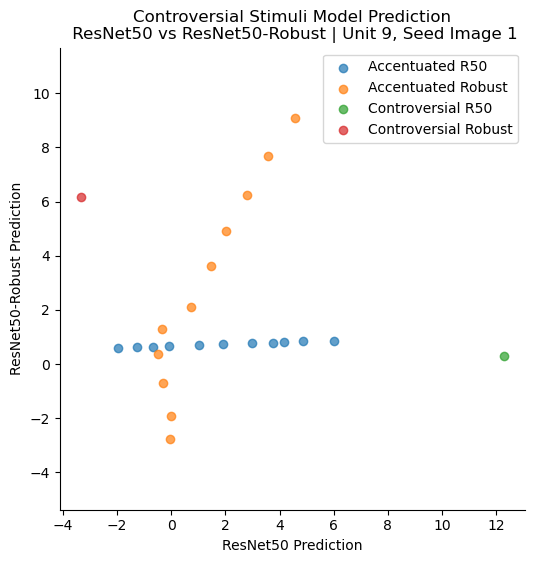

In [82]:
target_unit = 9
seed_img = 1
plt.figure(figsize=(6, 6))
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").index
plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Accentuated R50")
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").index
plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Accentuated Robust")
img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit and img==@seed_img").index
plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Controversial R50")
img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit and img==@seed_img").index
plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Controversial Robust")
plt.axis("equal")
plt.xlabel("ResNet50 Prediction")
plt.ylabel("ResNet50-Robust Prediction")
plt.title(f"Controversial Stimuli Model Prediction\n ResNet50 vs ResNet50-Robust | Unit {target_unit}, Seed Image {seed_img}")
plt.legend()
saveallforms(figoutdir, f"controversial_accentuated_stimuli_model_prediction_ResNet50_vs_ResNet50-Robust_{subject_id3}_unit_{target_unit}_img_{seed_img}")


stimulus  accentuated   model  \
131  controversial_max_robust_MultiLassoCV_unit_9_i...        False  robust   

           method  unit  img  level  score  is_nsd  is_controversial  \
131  MultiLassoCV     9    1    NaN    NaN   False              True   

     score_robust  score_r50  
131      7.607554    -7.5549

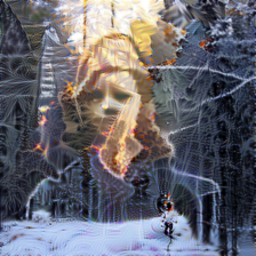

stimulus  accentuated model  \
61  controversial_max_r50_MultiLassoCV_unit_9_img_...        False   r50   

          method  unit  img  level  score  is_nsd  is_controversial  \
61  MultiLassoCV     9    1    NaN    NaN   False              True   

    score_robust  score_r50  
61      -0.69506  17.964798

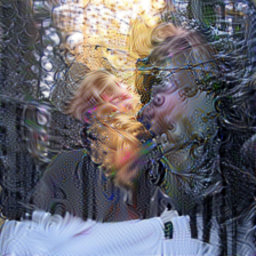

stimulus  accentuated  \
2356  robust_resnet50_MultiLassoCV_unit_9_img_1_leve...         True   

                model        method  unit  img    level      score  is_nsd  \
2356  robust_resnet50  MultiLassoCV     9    1  10.8031  10.796051   False   

      is_controversial  score_robust  score_r50  
2356             False           NaN        NaN

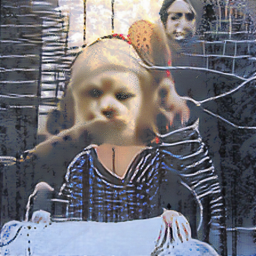

stimulus  accentuated     model  \
821  resnet50_MultiLassoCV_unit_9_img_1_level_9.279...         True  resnet50   

           method  unit  img     level     score  is_nsd  is_controversial  \
821  MultiLassoCV     9    1  9.279073  9.279785   False             False   

     score_robust  score_r50  
821           NaN        NaN

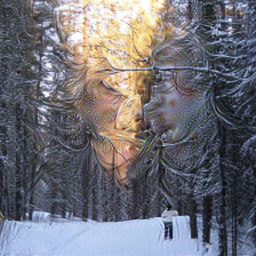

In [70]:
display(stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==9 and img==1"))
display_stimuli(stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==9 and img==1").index);
display(stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==9 and img==1"))
display_stimuli(stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==9 and img==1").index);
display(stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==9 and img==1").sort_values("level", ascending=True).iloc[-1:])
display_stimuli(stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==9 and img==1").sort_values("level", ascending=True).index[-1:]);
display(stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==9 and img==1").sort_values("level", ascending=True).iloc[-1:])
display_stimuli(stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==9 and img==1").sort_values("level", ascending=True).index[-1:]);

### Accentuation plot

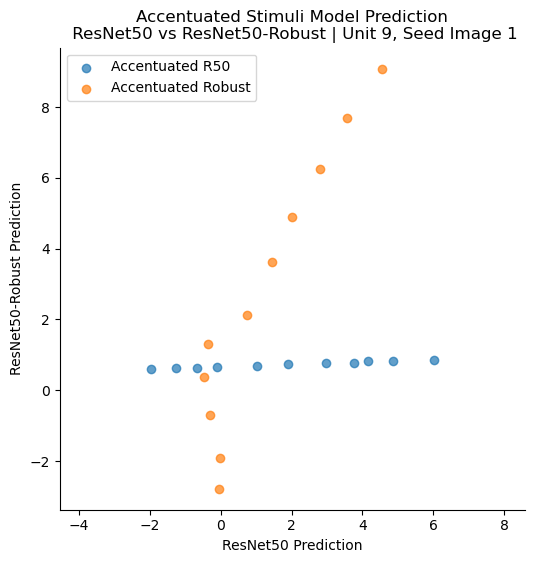

In [105]:
target_unit = 9
seed_img = 1
plt.figure(figsize=(6, 6))
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").index
plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Accentuated R50", marker="o")
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").index
scatter2 = plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Accentuated Robust", marker="o")
# img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit and img==@seed_img").index
# plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Controversial R50")
# img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit and img==@seed_img").index
# plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Controversial Robust")
plt.axis("equal")
plt.xlabel("ResNet50 Prediction")
plt.ylabel("ResNet50-Robust Prediction")
plt.title(f"Accentuated Stimuli Model Prediction\n ResNet50 vs ResNet50-Robust | Unit {target_unit}, Seed Image {seed_img}")
plt.legend()
saveallforms(figoutdir, f"accentuated_stimuli_model_prediction_ResNet50_vs_ResNet50-Robust_LassoCV_{subject_id3}_unit_{target_unit}_img_{seed_img}")

# # can you hide scatter2 plot and the legend?
# scatter2.set_visible(False)
# # plt.legend().set_visible(False)
# saveallforms(figoutdir, f"accentuated_stimuli_model_prediction_ResNet50_vs_ResNet50-Robust_LassoCV_{subject_id3}_unit_{target_unit}_img_{seed_img}_intermediate")


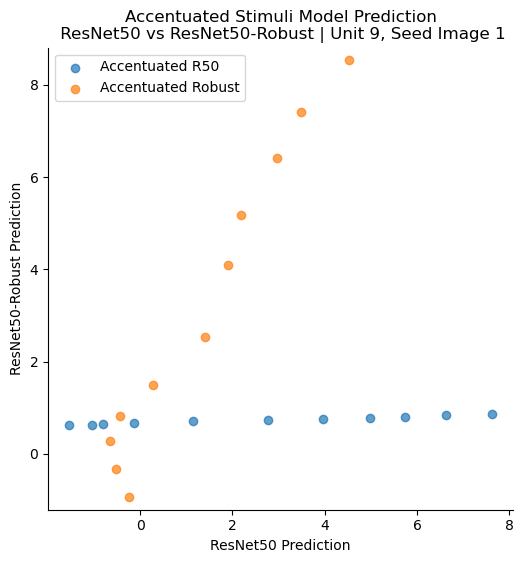

In [101]:
target_unit = 9
seed_img = 1
plt.figure(figsize=(6, 6))
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='RidgeCV' and unit==@target_unit and img==@seed_img").index
plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Accentuated R50")
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='RidgeCV' and unit==@target_unit and img==@seed_img").index
plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Accentuated Robust")
# img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit and img==@seed_img").index
# plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Controversial R50")
# img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit and img==@seed_img").index
# plt.scatter(ds3.RN50_Lasso[img_idx, target_unit], ds3.RN50rbst_Lasso[img_idx, target_unit], alpha=0.7, label="Controversial Robust")
plt.axis("equal")
plt.xlabel("ResNet50 Prediction")
plt.ylabel("ResNet50-Robust Prediction")
plt.title(f"Accentuated Stimuli Model Prediction\n ResNet50 vs ResNet50-Robust | Unit {target_unit}, Seed Image {seed_img}")
plt.legend()
saveallforms(figoutdir, f"accentuated_stimuli_model_prediction_ResNet50_vs_ResNet50-Robust_RidgeCV_{subject_id3}_unit_{target_unit}_img_{seed_img}")


### Model response peer review


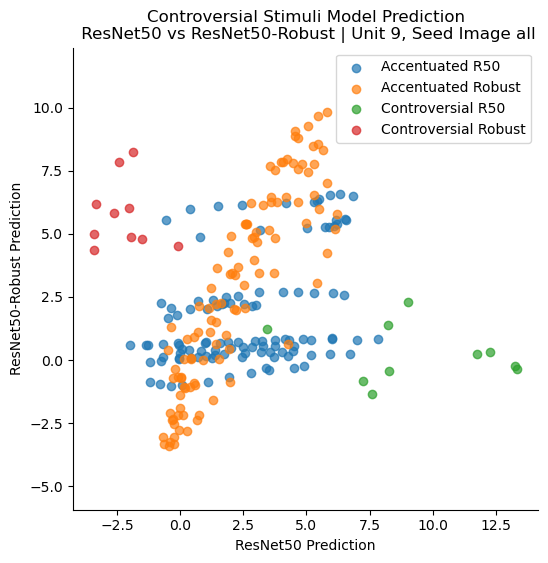

In [91]:
x_var = "RN50_Lasso"
y_var = "RN50rbst_Lasso"
target_unit = 9
plt.figure(figsize=(6, 6))
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated R50")
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated Robust")
img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial R50")
img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial Robust")
plt.axis("equal")
plt.xlabel("ResNet50 Prediction")
plt.ylabel("ResNet50-Robust Prediction")
plt.title(f"Controversial Stimuli Model Prediction\n ResNet50 vs ResNet50-Robust | Unit {target_unit}, Seed Image all")
plt.legend()
saveallforms(figoutdir, f"controversial_accentuated_stimuli_model_prediction_ResNet50_vs_ResNet50-Robust_{subject_id3}_unit_{target_unit}_all_seed_img")


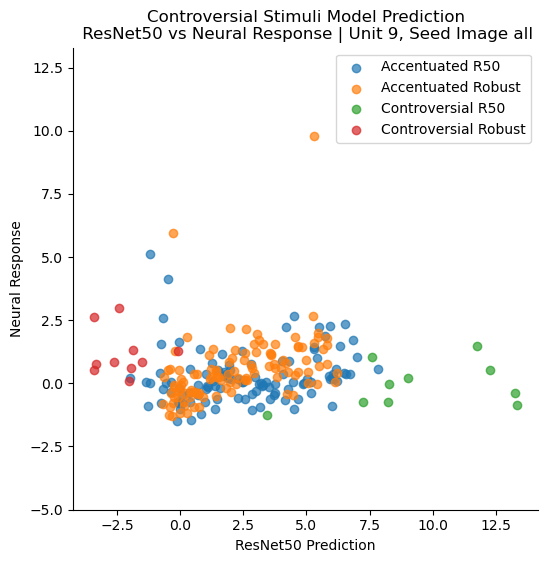

In [89]:
x_var = "RN50_Lasso"
y_var = "neural_response"
target_unit = 9
plt.figure(figsize=(6, 6))
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated R50")
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated Robust")
img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial R50")
img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial Robust")
plt.axis("equal")
plt.xlabel("ResNet50 Prediction")
plt.ylabel("Neural Response")
plt.title(f"Controversial Stimuli Model Prediction\n ResNet50 vs Neural Response | Unit {target_unit}, Seed Image all")
plt.legend()
saveallforms(figoutdir, f"controversial_accentuated_stimuli_model_prediction_ResNet50_vs_neural_response_{subject_id3}_unit_{target_unit}_all_seed_img")


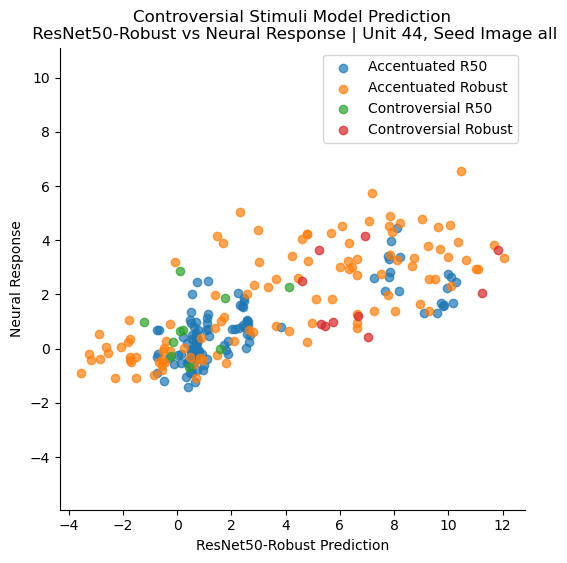

In [93]:
x_var = "RN50rbst_Lasso"
y_var = "neural_response"
target_unit = 44
plt.figure(figsize=(6, 6))
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated R50")
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated Robust")
img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial R50")
img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").index
plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial Robust")
plt.axis("equal")
plt.xlabel("ResNet50-Robust Prediction")
plt.ylabel("Neural Response")
plt.title(f"Controversial Stimuli Model Prediction\n ResNet50-Robust vs Neural Response | Unit {target_unit}, Seed Image all")
plt.legend()
saveallforms(figoutdir, f"controversial_accentuated_stimuli_model_prediction_ResNet50-Robust_vs_neural_response_{subject_id3}_unit_{target_unit}_all_seed_img")

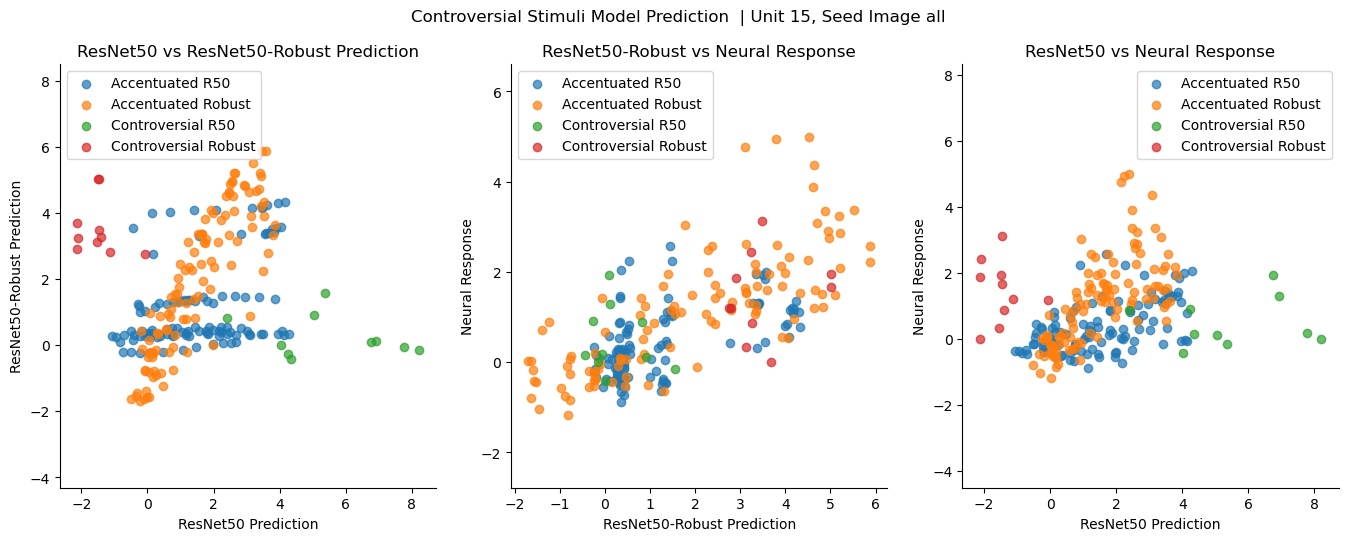

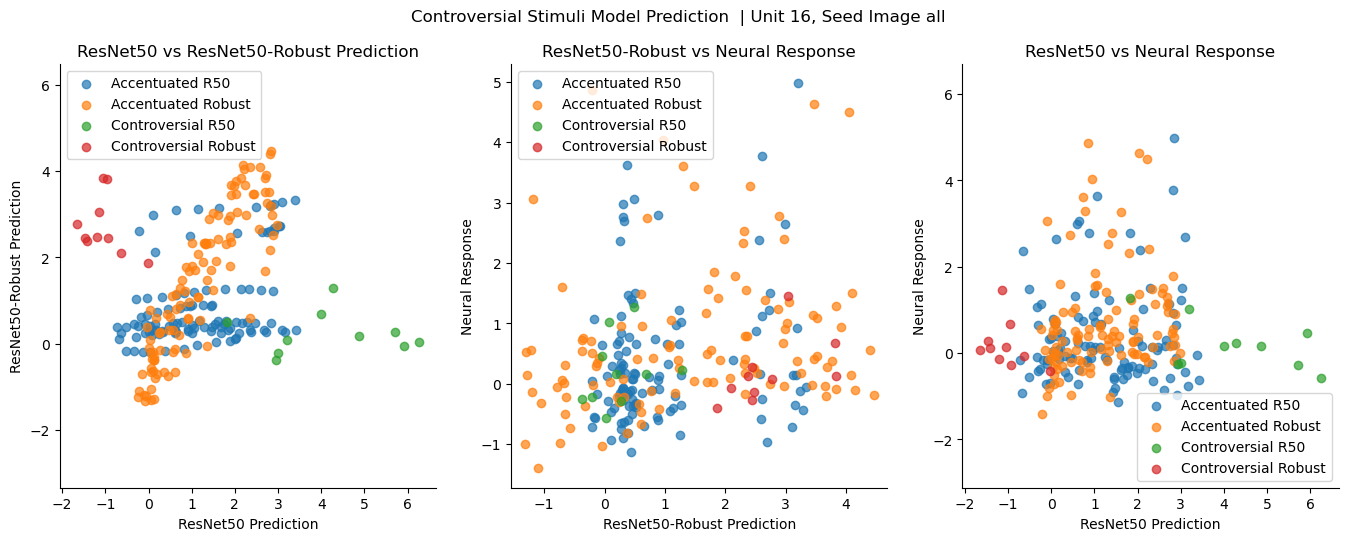

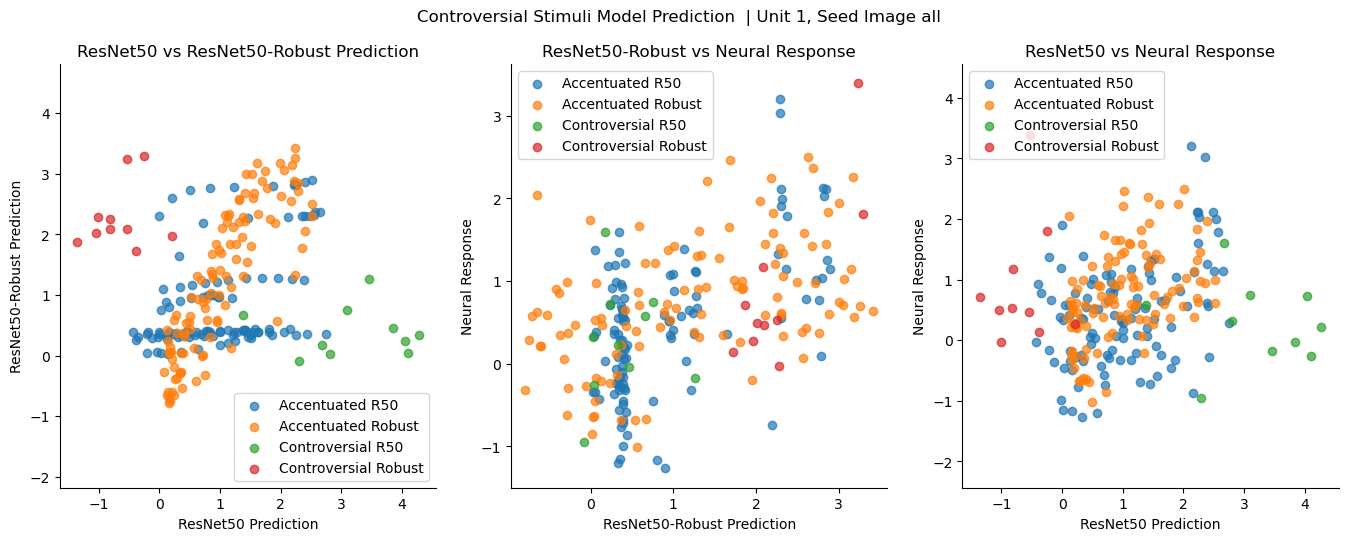

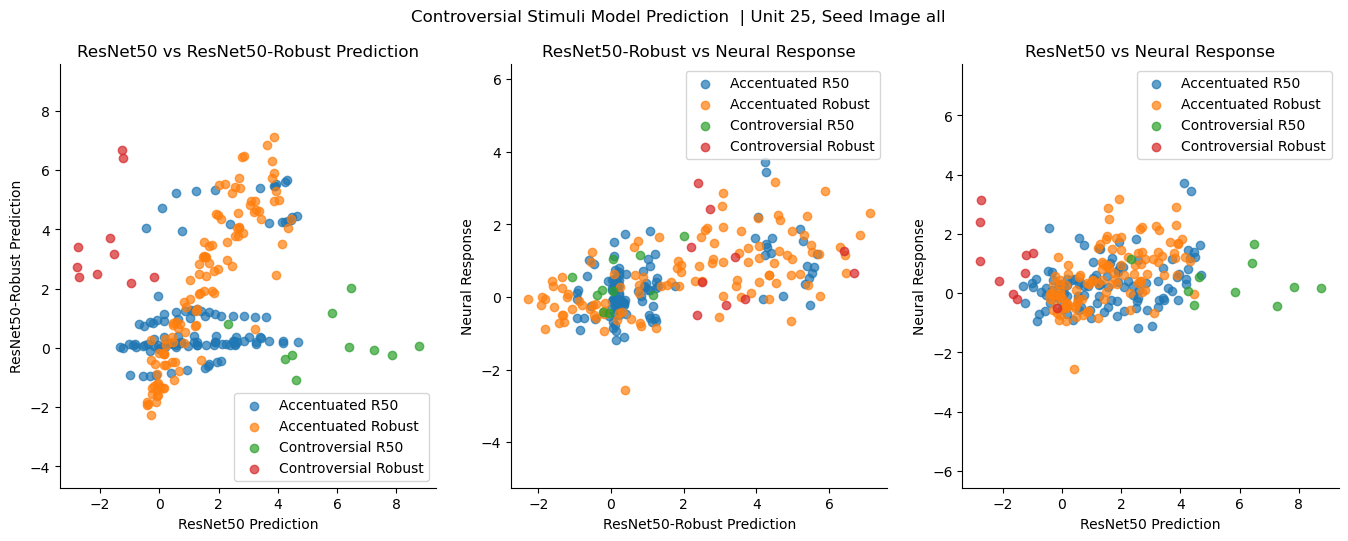

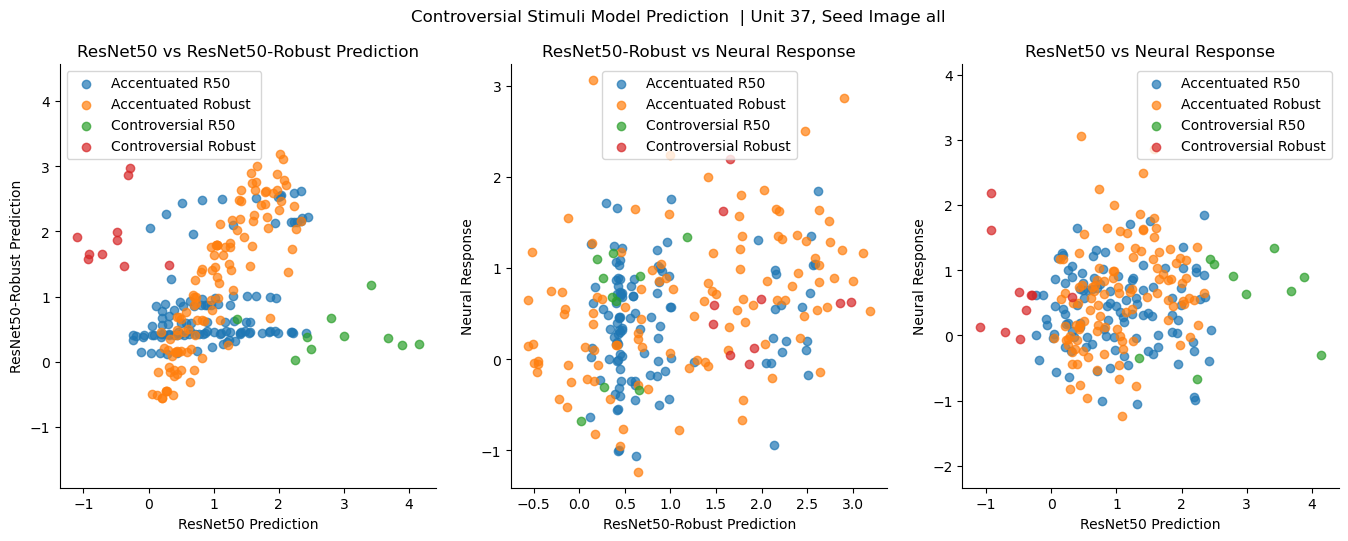

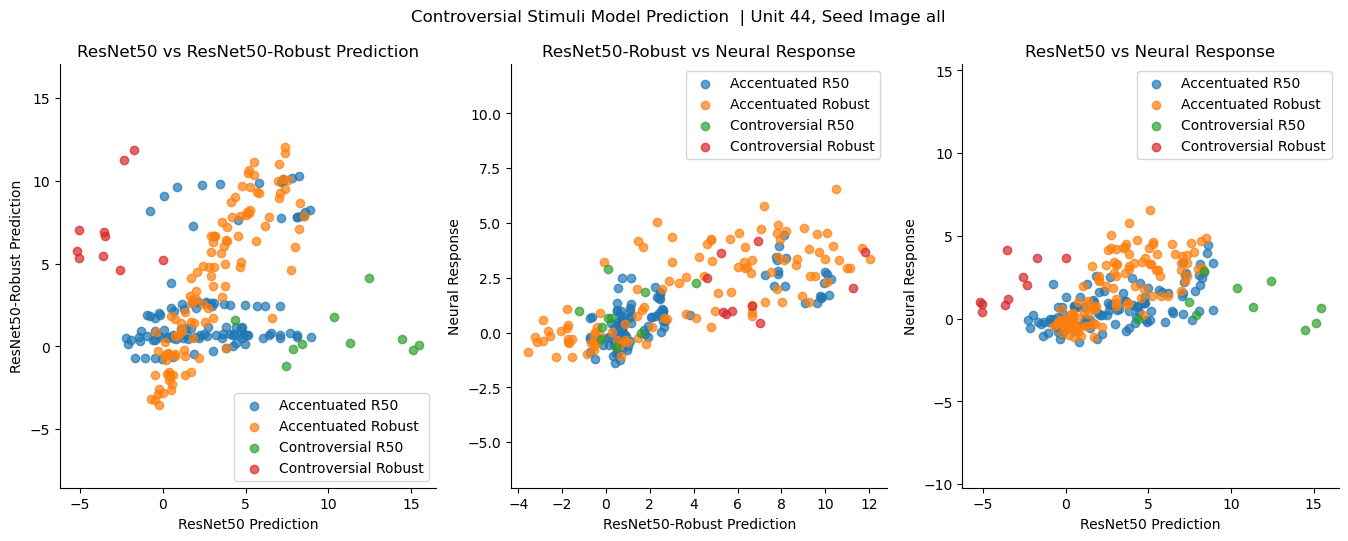

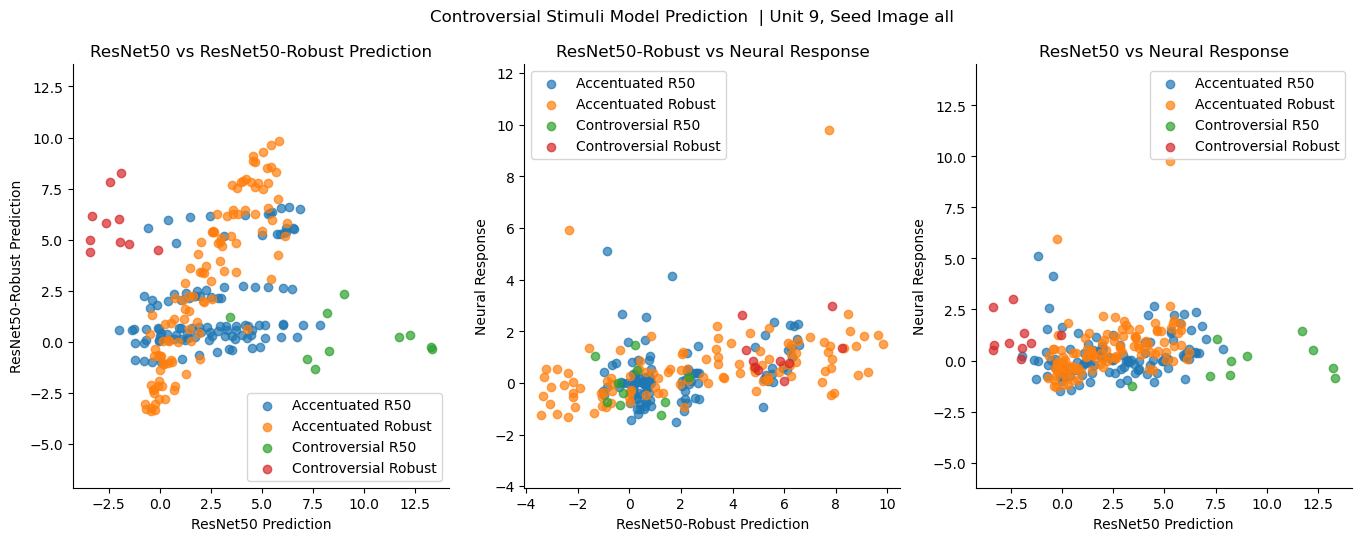

In [98]:

target_unit = 44
for target_unit in stim_contrv_meta_df.unit.unique():
    if pd.isna(target_unit):
        continue
        
    figh, axs = plt.subplots(1, 3, figsize=(16.5, 5.5))
    x_var = "RN50_Lasso"
    y_var = "RN50rbst_Lasso"
    plt.sca(axs[0])
    img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated R50")
    img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated Robust")
    img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial R50")
    img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial Robust")
    plt.axis("equal")
    plt.xlabel("ResNet50 Prediction")
    plt.ylabel("ResNet50-Robust Prediction")
    plt.title(f"ResNet50 vs ResNet50-Robust Prediction")
    plt.legend()

    x_var = "RN50rbst_Lasso"
    y_var = "neural_response"
    plt.sca(axs[1])
    img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated R50")
    img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated Robust")
    img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial R50")
    img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial Robust")
    plt.axis("equal")
    plt.xlabel("ResNet50-Robust Prediction")
    plt.ylabel("Neural Response")
    plt.title(f"ResNet50-Robust vs Neural Response")
    plt.legend()

    x_var = "RN50_Lasso"
    y_var = "neural_response"
    plt.sca(axs[2])
    img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated R50")
    img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Accentuated Robust")
    img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial R50")
    img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").index
    plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial Robust")
    plt.axis("equal")
    plt.xlabel("ResNet50 Prediction")
    plt.ylabel("Neural Response")
    plt.title(f"ResNet50 vs Neural Response")
    plt.suptitle(f"Controversial Stimuli Model Prediction  | Unit {target_unit}, Seed Image all")
    plt.legend()
    saveallforms(figoutdir, f"controversial_accentuated_stimuli_prediction_validation_ResNet50_vs_ResNet50-Robust_vs_neural_response_{subject_id3}_unit_{target_unit}_all_seed_img")
    plt.show()

### Alternative Shared Barplot format

In [23]:
stim_contrv_meta_df.iloc[img_idx]

stimulus  accentuated     model  \
811  resnet50_MultiLassoCV_unit_9_img_1_level_-0.82...         True  resnet50   
812  resnet50_MultiLassoCV_unit_9_img_1_level_-2.08...         True  resnet50   
813  resnet50_MultiLassoCV_unit_9_img_1_level_-3.34...         True  resnet50   
814  resnet50_MultiLassoCV_unit_9_img_1_level_0.439...         True  resnet50   
815  resnet50_MultiLassoCV_unit_9_img_1_level_1.702...         True  resnet50   
816  resnet50_MultiLassoCV_unit_9_img_1_level_2.965...         True  resnet50   
817  resnet50_MultiLassoCV_unit_9_img_1_level_4.228...         True  resnet50   
818  resnet50_MultiLassoCV_unit_9_img_1_level_5.490...         True  resnet50   
819  resnet50_MultiLassoCV_unit_9_img_1_level_6.753...         True  resnet50   
820  resnet50_MultiLassoCV_unit_9_img_1_level_8.016...         True  resnet50   
821  resnet50_MultiLassoCV_unit_9_img_1_level_9.279...         True  resnet50   

           method  unit  img     level     score  is_nsd  is_controversial  \
811  MultiLassoCV     9    1 -0.823035 -0.815443   False             False   
812  MultiLassoCV     9    1 -2.085798 -2.080226   False             False   
813  MultiLassoCV     9    1 -3.348562 -3.342080   False             False   
814  MultiLassoCV     9    1  0.439729  0.433834   False             False   
815  MultiLassoCV     9    1  1.702492  1.697557   False             False   
816  MultiLassoCV     9    1  2.965256  2.962239   False             False   
817  MultiLassoCV     9    1  4.228019  4.237629   False             False   
818  MultiLassoCV     9    1  5.490783  5.485075   False             False   
819  MultiLassoCV     9    1  6.753546  6.759262   False             False   
820  MultiLassoCV     9    1  8.016310  8.020585   False             False   
821  MultiLassoCV     9    1  9.279073  9.279785   False             False   

     score_robust  score_r50  
811           NaN        NaN  
812           NaN        NaN  
813           NaN        NaN  
814           NaN        NaN  
815           NaN        NaN  
816           NaN        NaN  
817           NaN        NaN  
818           NaN        NaN  
819           NaN        NaN  
820           NaN        NaN  
821           NaN        NaN

In [30]:
stim_contrv_meta_df.model.unique()

array(['r50', 'robust', 'resnet50', 'robust_resnet50', nan], dtype=object)

Text(0.5, 0, 'levels')

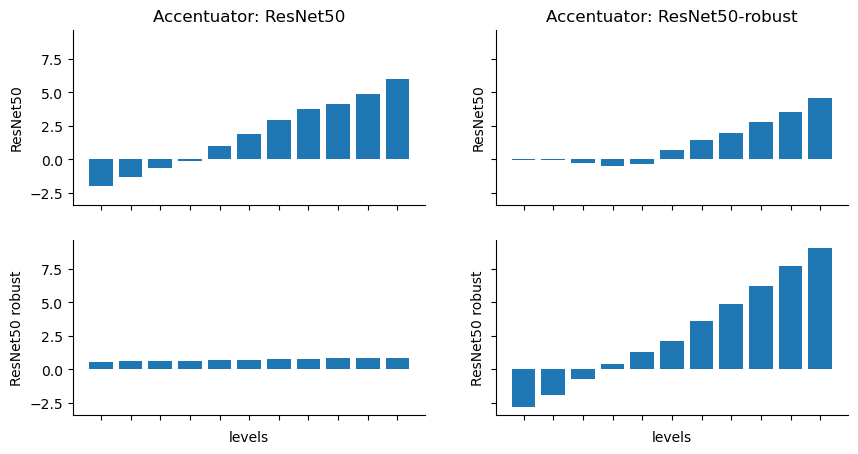

In [35]:
target_unit = 9
seed_img = 1
figh, axs = plt.subplots(2,2,figsize=(10, 5),sharex=True,sharey=True)
plt.sca(axs[0, 0])
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.RN50_Lasso[img_idx, target_unit])
plt.xticks(range(len(img_idx)),[])
plt.ylabel("ResNet50")
plt.title("Accentuator: ResNet50")

plt.sca(axs[0, 1])
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.RN50_Lasso[img_idx, target_unit])
plt.xticks(range(len(img_idx)),[])
plt.ylabel("ResNet50")
plt.title("Accentuator: ResNet50-robust")

plt.sca(axs[1, 0])
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.RN50rbst_Lasso[img_idx, target_unit])
plt.xticks(range(len(img_idx)),[])
plt.ylabel("ResNet50 robust")
plt.xlabel("levels")
plt.sca(axs[1, 1])
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.RN50rbst_Lasso[img_idx, target_unit])
plt.xticks(range(len(img_idx)),[])
plt.ylabel("ResNet50 robust")
plt.xlabel("levels")

In [36]:
ds3

<xarray.Dataset> Size: 8MB
Dimensions:          (stimulus: 3420, unit: 64)
Coordinates:
  * stimulus         (stimulus) <U107 1MB 'controversial_max_r50_MultiLassoCV...
    image_path       (stimulus) <U184 3MB ...
  * unit             (unit) int64 512B 0 1 2 3 4 5 6 7 ... 57 58 59 60 61 62 63
Data variables:
    neural_response  (stimulus, unit) float32 876kB ...
    RN50_Lasso       (stimulus, unit) float32 876kB ...
    RN50_Ridge       (stimulus, unit) float32 876kB ...
    RN50rbst_Lasso   (stimulus, unit) float32 876kB ...
    RN50rbst_Ridge   (stimulus, unit) float32 876kB ...

Text(0.5, 0, 'levels')

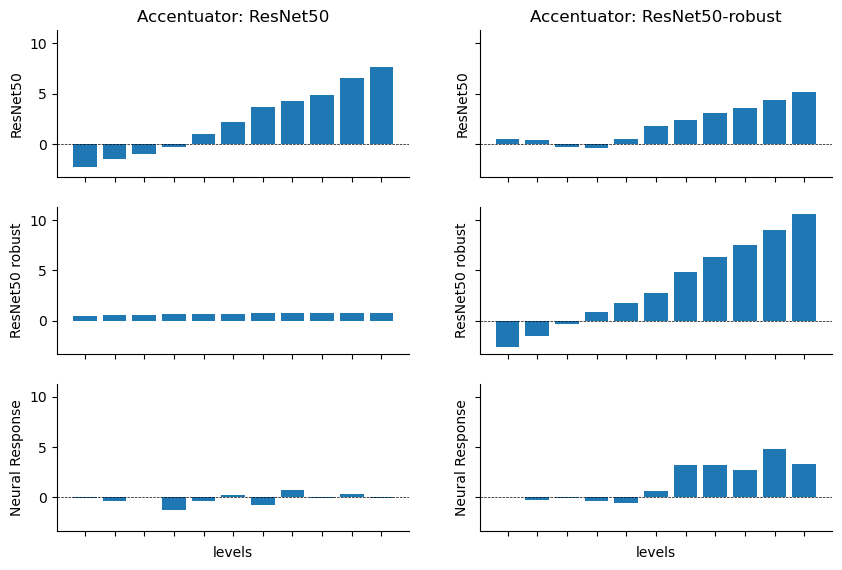

In [49]:
target_unit = 44
seed_img = 1
figh, axs = plt.subplots(3,2,figsize=(10, 6.5),sharex=True,sharey=True)
plt.sca(axs[0, 0])
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.RN50_Lasso[img_idx, target_unit])
plt.axhline(0, linestyle="--", lw=0.5, c='k')
plt.xticks(range(len(img_idx)),[])
plt.ylabel("ResNet50")
plt.title("Accentuator: ResNet50")

plt.sca(axs[0, 1])
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.RN50_Lasso[img_idx, target_unit])
plt.axhline(0, linestyle="--", lw=0.5, c='k')
plt.xticks(range(len(img_idx)),[])
plt.ylabel("ResNet50")
plt.title("Accentuator: ResNet50-robust")

plt.sca(axs[1, 0])
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.RN50rbst_Lasso[img_idx, target_unit])
plt.xticks(range(len(img_idx)),[])
plt.ylabel("ResNet50 robust")
plt.sca(axs[1, 1])
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.RN50rbst_Lasso[img_idx, target_unit])
plt.axhline(0, linestyle="--", lw=0.5, c='k')
plt.xticks(range(len(img_idx)),[])
plt.ylabel("ResNet50 robust")

plt.sca(axs[2, 0])
img_idx = stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.neural_response[img_idx, target_unit])
plt.axhline(0, linestyle="--", lw=0.5, c='k')
plt.xticks(range(len(img_idx)),[])
plt.ylabel("Neural Response")
plt.xlabel("levels")
plt.sca(axs[2, 1])
img_idx = stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
plt.bar(range(len(img_idx)),ds3.neural_response[img_idx, target_unit])
plt.axhline(0, linestyle="--", lw=0.5, c='k')
plt.xticks(range(len(img_idx)),[])
plt.ylabel("Neural Response")
plt.xlabel("levels")


In [57]:
figoutdir

'/n/home12/binxuwang/Github/Closed-loop-visual-insilico/figures/red_20250123-20250126/controversial_analysis'

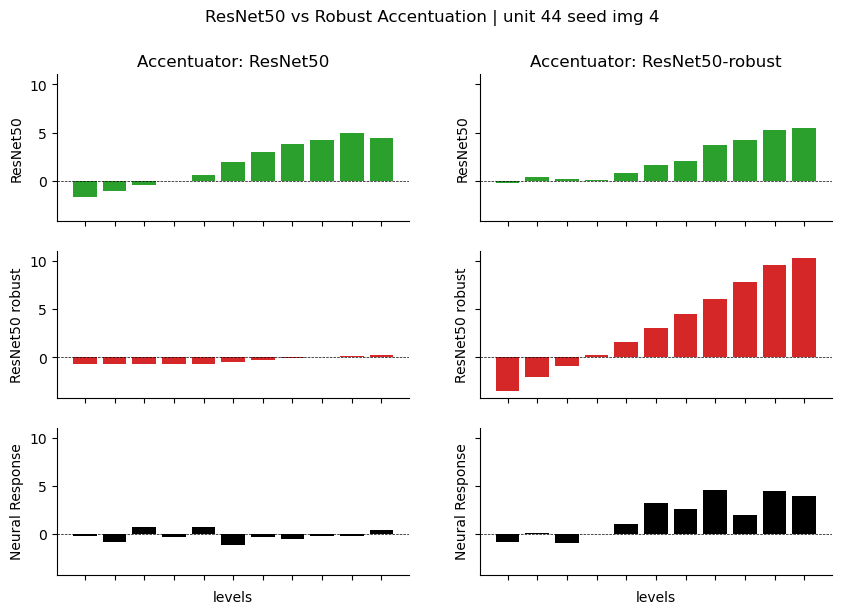

In [58]:
def get_plot_data(stim_df, ds, target_unit, seed_img, model, data_type):
    """
    Get data for plotting a specific panel.
    
    Parameters:
    -----------
    stim_df : DataFrame
        DataFrame containing stimulus metadata
    ds : xarray.Dataset
        Dataset containing neural responses and model predictions
    target_unit : int
        Target unit to plot
    seed_img : int
        Seed image index
    model : str
        Model name ('resnet50' or 'robust_resnet50')
    data_type : str
        Type of data to plot ('RN50_Lasso', 'RN50rbst_Lasso', or 'neural_response')
    
    Returns:
    --------
    tuple
        (indices, values) for plotting
    """
    img_idx = stim_df.query(f"accentuated and model=='{model}' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
    values = ds[data_type][img_idx, target_unit]
    return img_idx, values

def plot_barplot_panel(ax, img_idx, values, ylabel, title=None, show_xticklabels=False, xlabel=None, color='C0'):
    """
    Plot a single panel in the figure.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        Axes to plot on
    img_idx : array-like
        Indices of images to plot
    values : array-like
        Values to plot
    ylabel : str
        Y-axis label
    title : str, optional
        Title for the panel
    show_xticklabels : bool, optional
        Whether to show x-tick labels
    xlabel : str, optional
        X-axis label
    """
    plt.sca(ax)
    plt.bar(range(len(img_idx)), values, color=color)
    plt.axhline(0, linestyle="--", lw=0.5, c='k')
    plt.xticks(range(len(img_idx)), [] if not show_xticklabels else range(len(img_idx)))
    plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if xlabel:
        plt.xlabel(xlabel)

# Main plotting code
target_unit = 44
seed_img = 4
figh, axs = plt.subplots(3, 2, figsize=(10, 6.5), sharex=True, sharey=True)
# Top row - ResNet50 responses
# Top row - ResNet50 responses
# Left panel - Accentuator: ResNet50
img_idx_resnet = stim_contrv_meta_df.query(f"accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
img_idx_robust = stim_contrv_meta_df.query(f"accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
values_resnet = ds3['RN50_Lasso'][img_idx_resnet, target_unit]
plot_barplot_panel(axs[0, 0], img_idx_resnet, values_resnet, "ResNet50", "Accentuator: ResNet50", color="C2")
# Right panel - Accentuator: ResNet50-robust
values_robust = ds3['RN50_Lasso'][img_idx_robust, target_unit]
plot_barplot_panel(axs[0, 1], img_idx_robust, values_robust, "ResNet50", "Accentuator: ResNet50-robust", color="C2")
# Middle row - ResNet50-robust responses
# Left panel - Accentuator: ResNet50
values_resnet_mid = ds3['RN50rbst_Lasso'][img_idx_resnet, target_unit]
plot_barplot_panel(axs[1, 0], img_idx_resnet, values_resnet_mid, "ResNet50 robust", color="C3")
# Right panel - Accentuator: ResNet50-robust
values_robust_mid = ds3['RN50rbst_Lasso'][img_idx_robust, target_unit]
plot_barplot_panel(axs[1, 1], img_idx_robust, values_robust_mid, "ResNet50 robust", color="C3")
# Bottom row - Neural responses
# Left panel - Accentuator: ResNet50
values_resnet_bot = ds3['neural_response'][img_idx_resnet, target_unit]
plot_barplot_panel(axs[2, 0], img_idx_resnet, values_resnet_bot, "Neural Response", xlabel="levels", color="k")
# Right panel - Accentuator: ResNet50-robust
values_robust_bot = ds3['neural_response'][img_idx_robust, target_unit]
plot_barplot_panel(axs[2, 1], img_idx_robust, values_robust_bot, "Neural Response", xlabel="levels", color="k")

plt.suptitle(f"ResNet50 vs Robust Accentuation | unit {target_unit} seed img {seed_img}")
saveallforms(figoutdir, f"Accentuation_r50_vs_robust_lasso_peer_review_unit_{target_unit}_seed_{seed_img}")

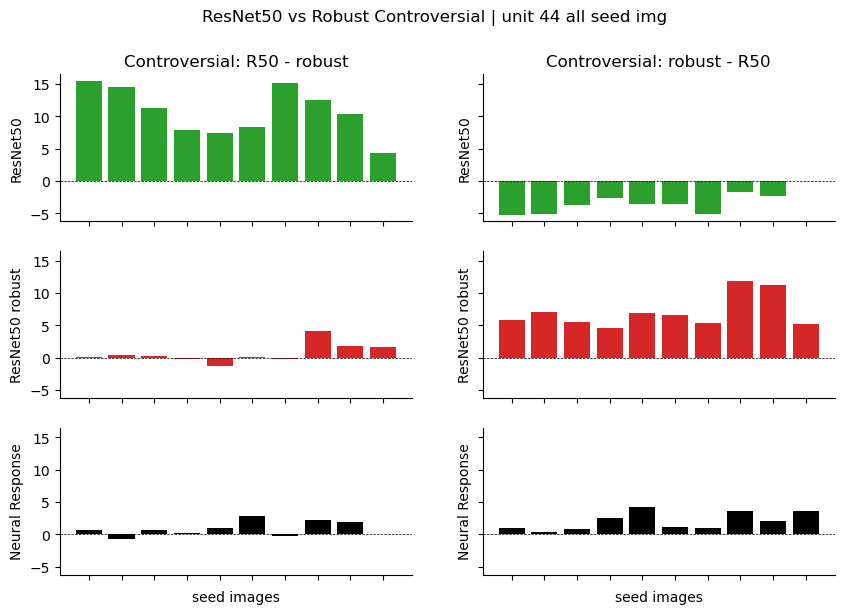

In [62]:

# Main plotting code
target_unit = 44
figh, axs = plt.subplots(3, 2, figsize=(10, 6.5), sharex=True, sharey=True)
# Top row - ResNet50 responses
# Left panel - Accentuator: ResNet50
# img_idx = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").index
# plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial R50")
# img_idx = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").index
# plt.scatter(ds3[x_var][img_idx, target_unit], ds3[y_var][img_idx, target_unit], alpha=0.7, label="Controversial Robust")
img_idx_resnet = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").sort_values("img").index
img_idx_robust = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").sort_values("img").index
# img_idx_resnet = stim_contrv_meta_df.query(f"contro and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
# img_idx_robust = stim_contrv_meta_df.query(f"accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
values_resnet = ds3['RN50_Lasso'][img_idx_resnet, target_unit]
plot_barplot_panel(axs[0, 0], img_idx_resnet, values_resnet, "ResNet50", "Controversial: R50 - robust", color="C2")
# Right panel - Accentuator: ResNet50-robust
values_robust = ds3['RN50_Lasso'][img_idx_robust, target_unit]
plot_barplot_panel(axs[0, 1], img_idx_robust, values_robust, "ResNet50", "Controversial: robust - R50", color="C2")
# Middle row - ResNet50-robust responses
# Left panel - Accentuator: ResNet50
values_resnet_mid = ds3['RN50rbst_Lasso'][img_idx_resnet, target_unit]
plot_barplot_panel(axs[1, 0], img_idx_resnet, values_resnet_mid, "ResNet50 robust", color="C3")
# Right panel - Accentuator: ResNet50-robust
values_robust_mid = ds3['RN50rbst_Lasso'][img_idx_robust, target_unit]
plot_barplot_panel(axs[1, 1], img_idx_robust, values_robust_mid, "ResNet50 robust", color="C3")
# Bottom row - Neural responses
# Left panel - Accentuator: ResNet50
values_resnet_bot = ds3['neural_response'][img_idx_resnet, target_unit]
plot_barplot_panel(axs[2, 0], img_idx_resnet, values_resnet_bot, "Neural Response", xlabel="seed images", color="k")
# Right panel - Accentuator: ResNet50-robust
values_robust_bot = ds3['neural_response'][img_idx_robust, target_unit]
plot_barplot_panel(axs[2, 1], img_idx_robust, values_robust_bot, "Neural Response", xlabel="seed images", color="k")

plt.suptitle(f"ResNet50 vs Robust Controversial | unit {target_unit} all seed img")
saveallforms(figoutdir, f"controversial_r50_vs_robust_lasso_peer_review_unit_{target_unit}_all_seed")

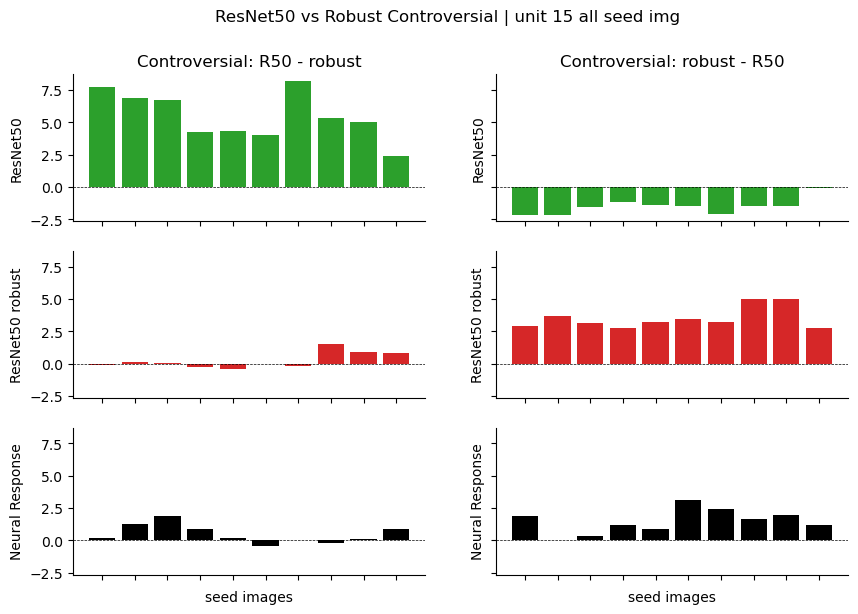

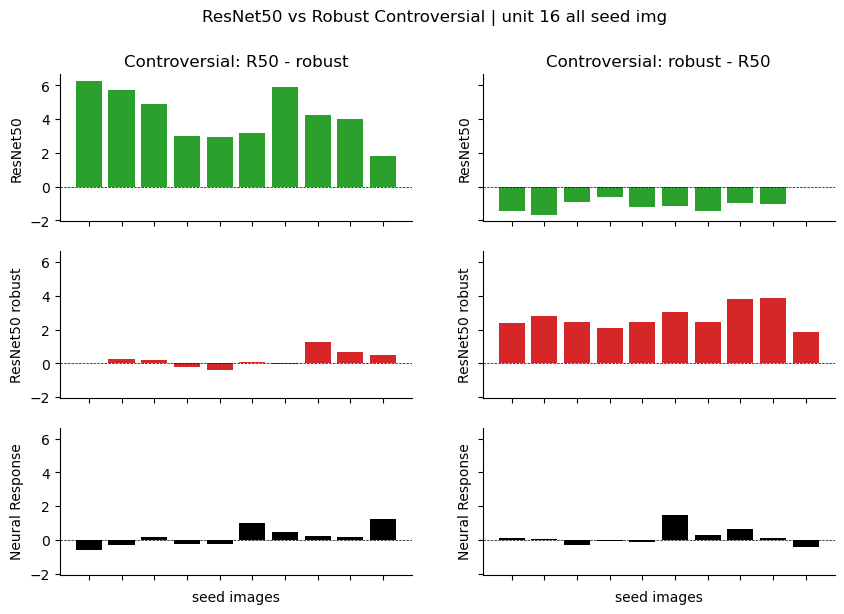

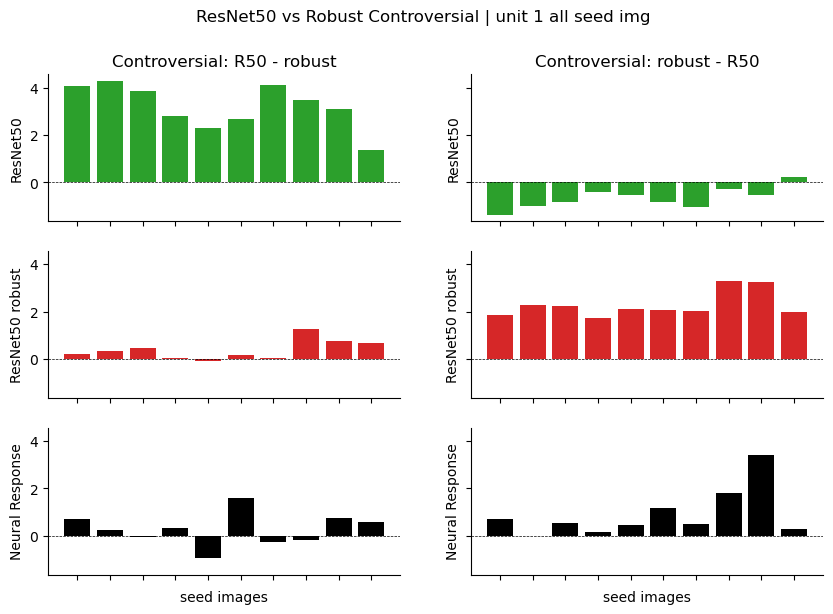

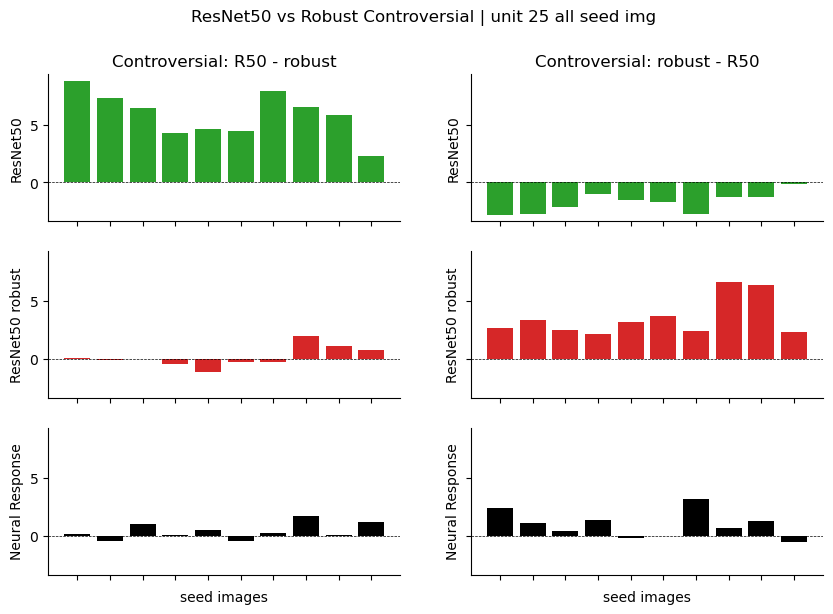

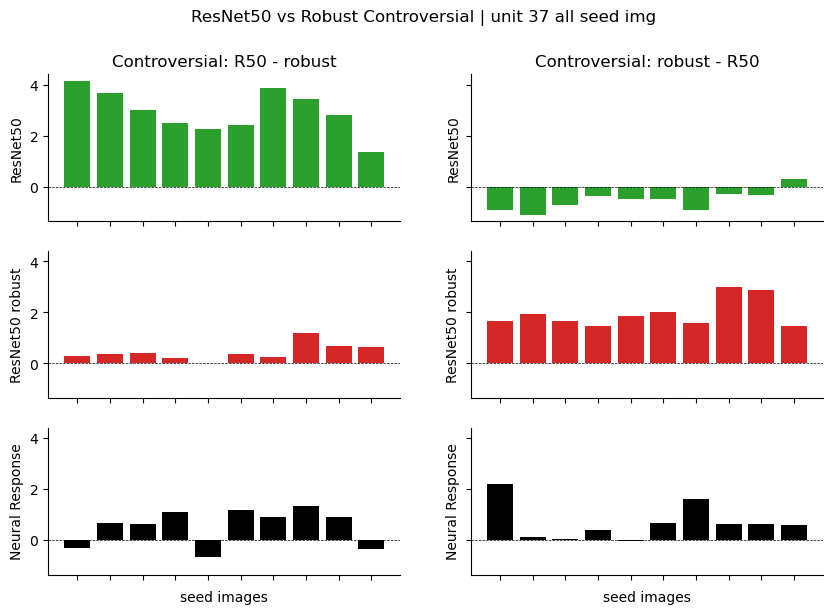

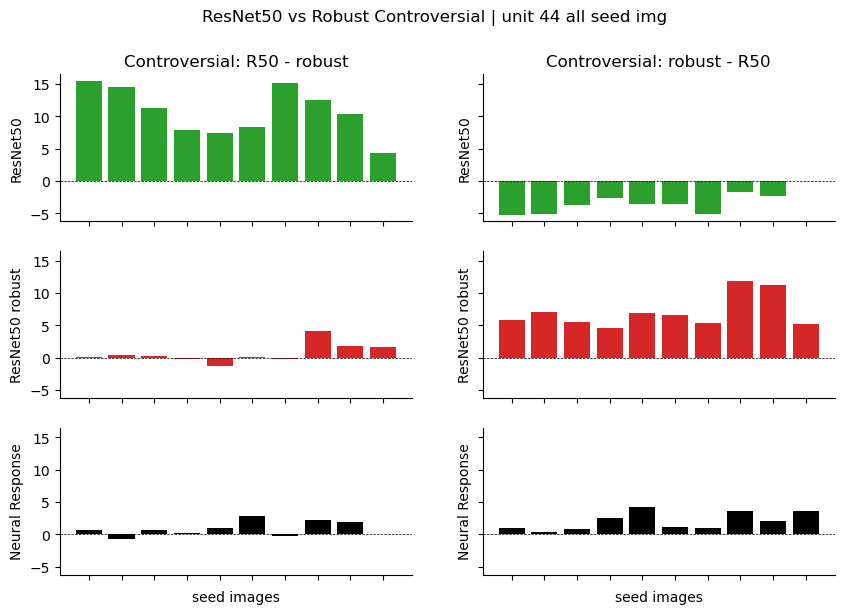

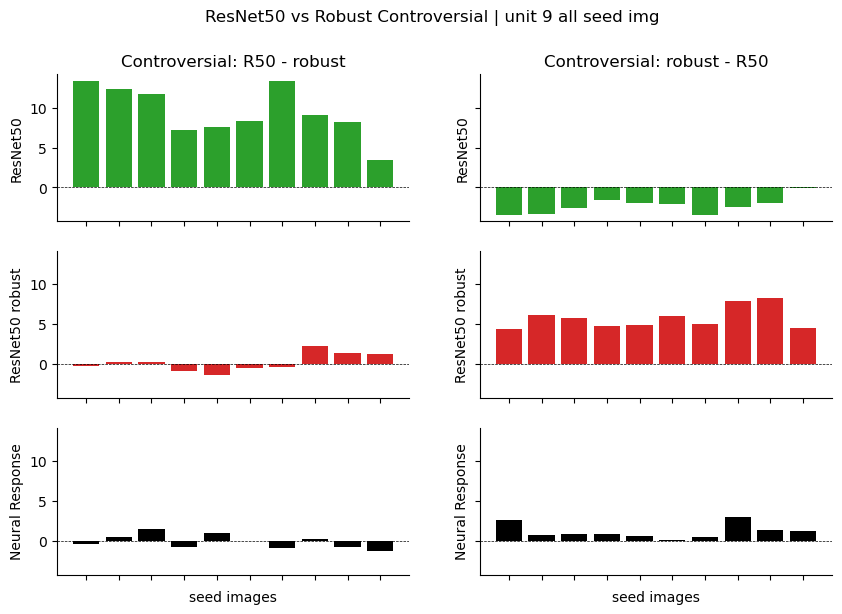

In [64]:

# Main plotting code
for target_unit in stim_contrv_meta_df.unit.unique():
    if pd.isna(target_unit):
        continue
    figh, axs = plt.subplots(3, 2, figsize=(10, 6.5), sharex=True, sharey=True)
    # Top row - ResNet50 responses
    # Left panel - Accentuator: ResNet50
    img_idx_resnet = stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==@target_unit ").sort_values("img").index
    img_idx_robust = stim_contrv_meta_df.query("is_controversial and model=='robust' and unit==@target_unit ").sort_values("img").index
    # img_idx_resnet = stim_contrv_meta_df.query(f"contro and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
    # img_idx_robust = stim_contrv_meta_df.query(f"accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
    values_resnet = ds3['RN50_Lasso'][img_idx_resnet, target_unit]
    plot_barplot_panel(axs[0, 0], img_idx_resnet, values_resnet, "ResNet50", "Controversial: R50 - robust", color="C2")
    # Right panel - Accentuator: ResNet50-robust
    values_robust = ds3['RN50_Lasso'][img_idx_robust, target_unit]
    plot_barplot_panel(axs[0, 1], img_idx_robust, values_robust, "ResNet50", "Controversial: robust - R50", color="C2")
    # Middle row - ResNet50-robust responses
    # Left panel - Accentuator: ResNet50
    values_resnet_mid = ds3['RN50rbst_Lasso'][img_idx_resnet, target_unit]
    plot_barplot_panel(axs[1, 0], img_idx_resnet, values_resnet_mid, "ResNet50 robust", color="C3")
    # Right panel - Accentuator: ResNet50-robust
    values_robust_mid = ds3['RN50rbst_Lasso'][img_idx_robust, target_unit]
    plot_barplot_panel(axs[1, 1], img_idx_robust, values_robust_mid, "ResNet50 robust", color="C3")
    # Bottom row - Neural responses
    # Left panel - Accentuator: ResNet50
    values_resnet_bot = ds3['neural_response'][img_idx_resnet, target_unit]
    plot_barplot_panel(axs[2, 0], img_idx_resnet, values_resnet_bot, "Neural Response", xlabel="seed images", color="k")
    # Right panel - Accentuator: ResNet50-robust
    values_robust_bot = ds3['neural_response'][img_idx_robust, target_unit]
    plot_barplot_panel(axs[2, 1], img_idx_robust, values_robust_bot, "Neural Response", xlabel="seed images", color="k")

    plt.suptitle(f"ResNet50 vs Robust Controversial | unit {target_unit} all seed img")
    saveallforms(figoutdir, f"controversial_r50_vs_robust_lasso_peer_review_unit_{target_unit}_all_seed")
    plt.show()

### Visualize accentuation stimuli

In [ ]:
target_unit = 44
seed_img = 4
img_idx_resnet = stim_contrv_meta_df.query(f"accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index
img_idx_robust = stim_contrv_meta_df.query(f"accentuated and model=='robust_resnet50' and method=='MultiLassoCV' and unit==@target_unit and img==@seed_img").sort_values("level").index

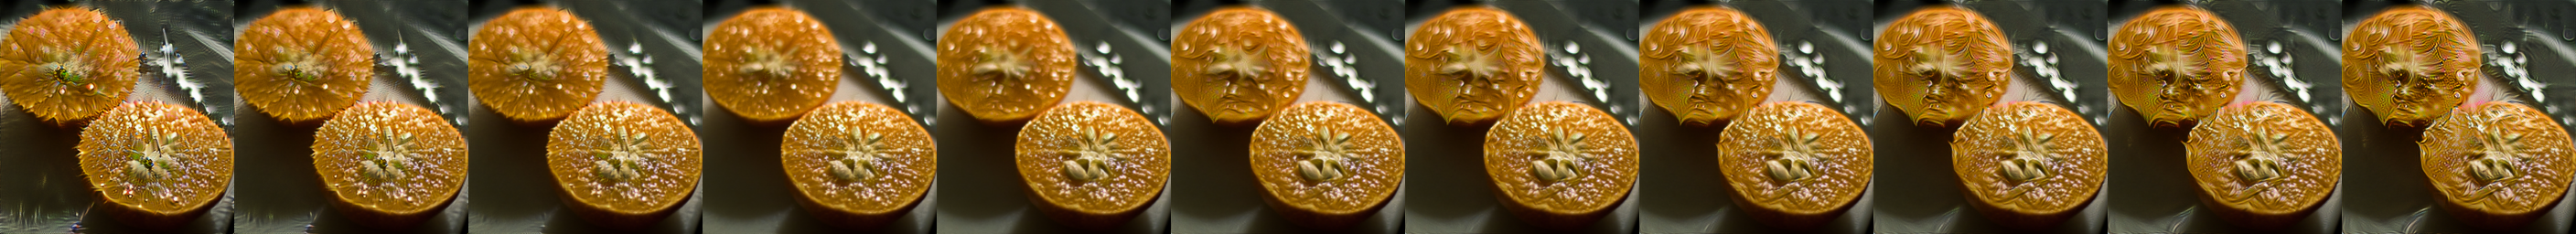

In [ ]:
display_stimuli(img_idx_resnet, cols=11);

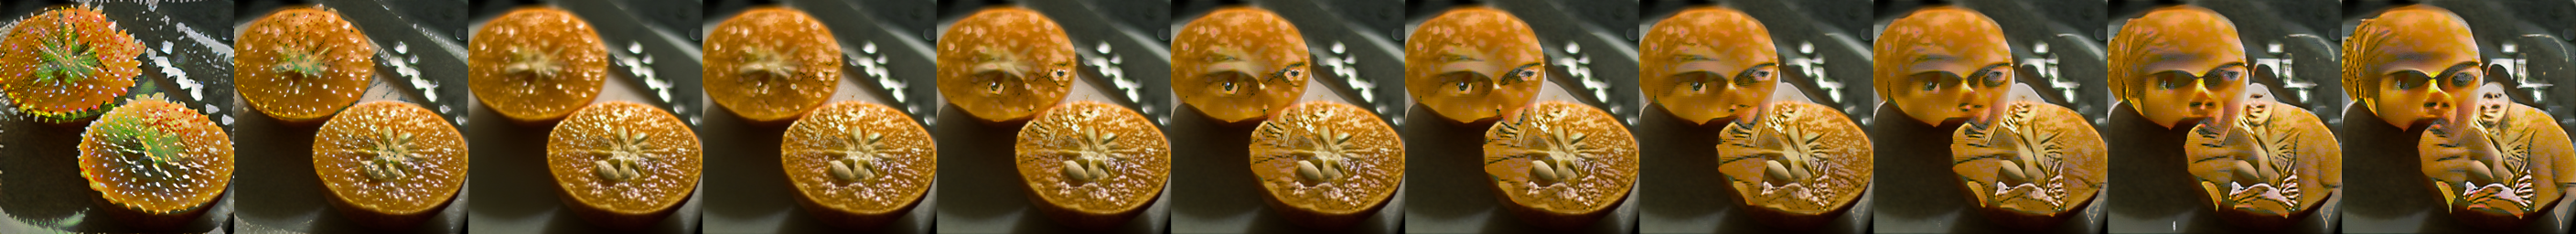

In [ ]:
display_stimuli(img_idx_robust, cols=11);

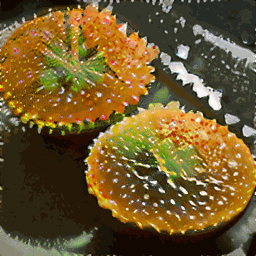

In [ ]:
# Create a gif from the images, cycling from lowest to highest level and back
from IPython.display import Image
import matplotlib.animation as animation
import numpy as np
import io
from PIL import Image as PILImage
display_stimuli

# Get the image paths in order of level
img_paths = [ds3.image_path[idx].data.item() for idx in img_idx_robust]

# Load all images
images = [PILImage.open(path).resize((256,256)) for path in img_paths]

# Create the forward and backward sequence for the gif
forward_sequence = images
backward_sequence = images[::-1][1:-1]  # Exclude first and last to avoid duplicates
gif_sequence = forward_sequence + backward_sequence

# Save as gif and display
gif_path = os.path.join("/n/home12/binxuwang/Github/Closed-loop-visual-insilico/figures/red_20250123-20250126/gif_animations", f"unit_{target_unit}_img_{seed_img}_robust_levels.gif")
gif_sequence[0].save(
    gif_path,
    save_all=True,
    append_images=gif_sequence[1:],
    duration=200,  # milliseconds per frame
    loop=0  # 0 means loop forever
)

# Display the gif
display(Image(gif_path))

In [27]:
stim_contrv_meta_df.query("is_controversial and model=='r50' and unit==9 and img==0")

stimulus  accentuated model  \
60  controversial_max_r50_MultiLassoCV_unit_9_img_...        False   r50   

          method  unit  img  level  score  is_nsd  is_controversial  \
60  MultiLassoCV     9    0    NaN    NaN   False              True   

    score_robust  score_r50  
60     -1.074824  18.780899

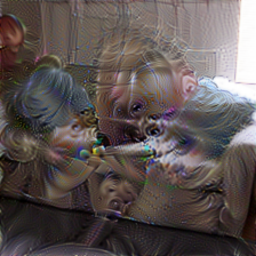

In [53]:
display(Image.open(ds3.image_path[60].data.item()).resize((256,256)))

In [38]:
stim_contrv_meta_df.query("accentuated and model=='robust_resnet50' and  method=='MultiLassoCV' and unit==9 and img==0").sort_values("level", ascending=True)

stimulus  accentuated  \
2343  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2342  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2341  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2340  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2344  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2346  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2347  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2348  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2349  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2350  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   
2345  robust_resnet50_MultiLassoCV_unit_9_img_0_leve...         True   

                model        method  unit  img      level      score  is_nsd  \
2343  robust_resnet50  MultiLassoCV     9    0  -4.912213  -4.409103   False   
2342  robust_resnet50  MultiLassoCV     9    0  -3.340682  -3.331356   False   
2341  robust_resnet50  MultiLassoCV     9    0  -1.769150  -1.761444   False   
2340  robust_resnet50  MultiLassoCV     9    0  -0.197619  -0.191155   False   
2344  robust_resnet50  MultiLassoCV     9    0   1.373912   1.364397   False   
2346  robust_resnet50  MultiLassoCV     9    0   2.945443   2.945934   False   
2347  robust_resnet50  MultiLassoCV     9    0   4.516975   4.516212   False   
2348  robust_resnet50  MultiLassoCV     9    0   6.088506   6.080525   False   
2349  robust_resnet50  MultiLassoCV     9    0   7.660037   7.652884   False   
2350  robust_resnet50  MultiLassoCV     9    0   9.231568   9.225677   False   
2345  robust_resnet50  MultiLassoCV     9    0  10.803100  10.709283   False   

      is_controversial  score_robust  score_r50  
2343             False           NaN        NaN  
2342             False           NaN        NaN  
2341             False           NaN        NaN  
2340             False           NaN        NaN  
2344             False           NaN        NaN  
2346             False           NaN        NaN  
2347             False           NaN        NaN  
2348             False           NaN        NaN  
2349             False           NaN        NaN  
2350             False           NaN        NaN  
2345             False           NaN        NaN

In [39]:
stim_contrv_meta_df.query("accentuated and model=='resnet50' and method=='MultiLassoCV' and unit==9 and img==0").sort_values("level", ascending=True)

stimulus  accentuated     model  \
802  resnet50_MultiLassoCV_unit_9_img_0_level_-3.34...         True  resnet50   
801  resnet50_MultiLassoCV_unit_9_img_0_level_-2.08...         True  resnet50   
800  resnet50_MultiLassoCV_unit_9_img_0_level_-0.82...         True  resnet50   
803  resnet50_MultiLassoCV_unit_9_img_0_level_0.439...         True  resnet50   
804  resnet50_MultiLassoCV_unit_9_img_0_level_1.702...         True  resnet50   
805  resnet50_MultiLassoCV_unit_9_img_0_level_2.965...         True  resnet50   
806  resnet50_MultiLassoCV_unit_9_img_0_level_4.228...         True  resnet50   
807  resnet50_MultiLassoCV_unit_9_img_0_level_5.490...         True  resnet50   
808  resnet50_MultiLassoCV_unit_9_img_0_level_6.753...         True  resnet50   
809  resnet50_MultiLassoCV_unit_9_img_0_level_8.016...         True  resnet50   
810  resnet50_MultiLassoCV_unit_9_img_0_level_9.279...         True  resnet50   

           method  unit  img     level     score  is_nsd  is_controversial  \
802  MultiLassoCV     9    0 -3.348562 -3.340968   False             False   
801  MultiLassoCV     9    0 -2.085798 -2.079441   False             False   
800  MultiLassoCV     9    0 -0.823035 -0.815266   False             False   
803  MultiLassoCV     9    0  0.439729  0.438525   False             False   
804  MultiLassoCV     9    0  1.702492  1.702690   False             False   
805  MultiLassoCV     9    0  2.965256  2.966581   False             False   
806  MultiLassoCV     9    0  4.228019  4.225494   False             False   
807  MultiLassoCV     9    0  5.490783  5.488327   False             False   
808  MultiLassoCV     9    0  6.753546  6.752391   False             False   
809  MultiLassoCV     9    0  8.016310  8.011930   False             False   
810  MultiLassoCV     9    0  9.279073  9.270064   False             False   

     score_robust  score_r50  
802           NaN        NaN  
801           NaN        NaN  
800           NaN        NaN  
803           NaN        NaN  
804           NaN        NaN  
805           NaN        NaN  
806           NaN        NaN  
807           NaN        NaN  
808           NaN        NaN  
809           NaN        NaN  
810           NaN        NaN

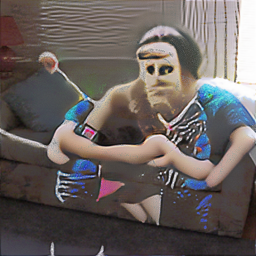

In [52]:
display(Image.open(ds3.image_path[2345].data.item()).resize((256,256)))

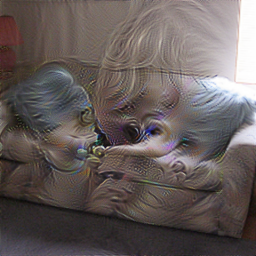

In [51]:
display(Image.open(ds3.image_path[810].data.item()).resize((256,256)))

In [20]:
sum(stim_contrv_meta_df.accentuated)

3080

In [21]:
sum(stim_contrv_meta_df.is_controversial)

140

In [22]:
sum(stim_contrv_meta_df.is_nsd)

200

### Analysis of controversial stimuli

In [18]:
from scipy.stats import pearsonr, ttest_ind, ttest_rel
figoutdir = join(figroot, "controversial_analysis")

In [132]:
target_unit_resp = []
for row in stim_contrv_meta_df.itertuples():
    if pd.isna(row.unit):
        target_unit_resp.append(np.nan)
    else:
        target_unit_resp.append(ds3.neural_response[row.Index, row.unit].item())
stim_contrv_meta_df["target_unit_resp"] = target_unit_resp
stim_contrv_meta_df["target_unit_resp"].astype(float)

0       0.171675
1       1.295927
2       1.924325
3       0.916825
4       0.162531
          ...   
3415         NaN
3416         NaN
3417         NaN
3418         NaN
3419         NaN
Name: target_unit_resp, Length: 3420, dtype: float64

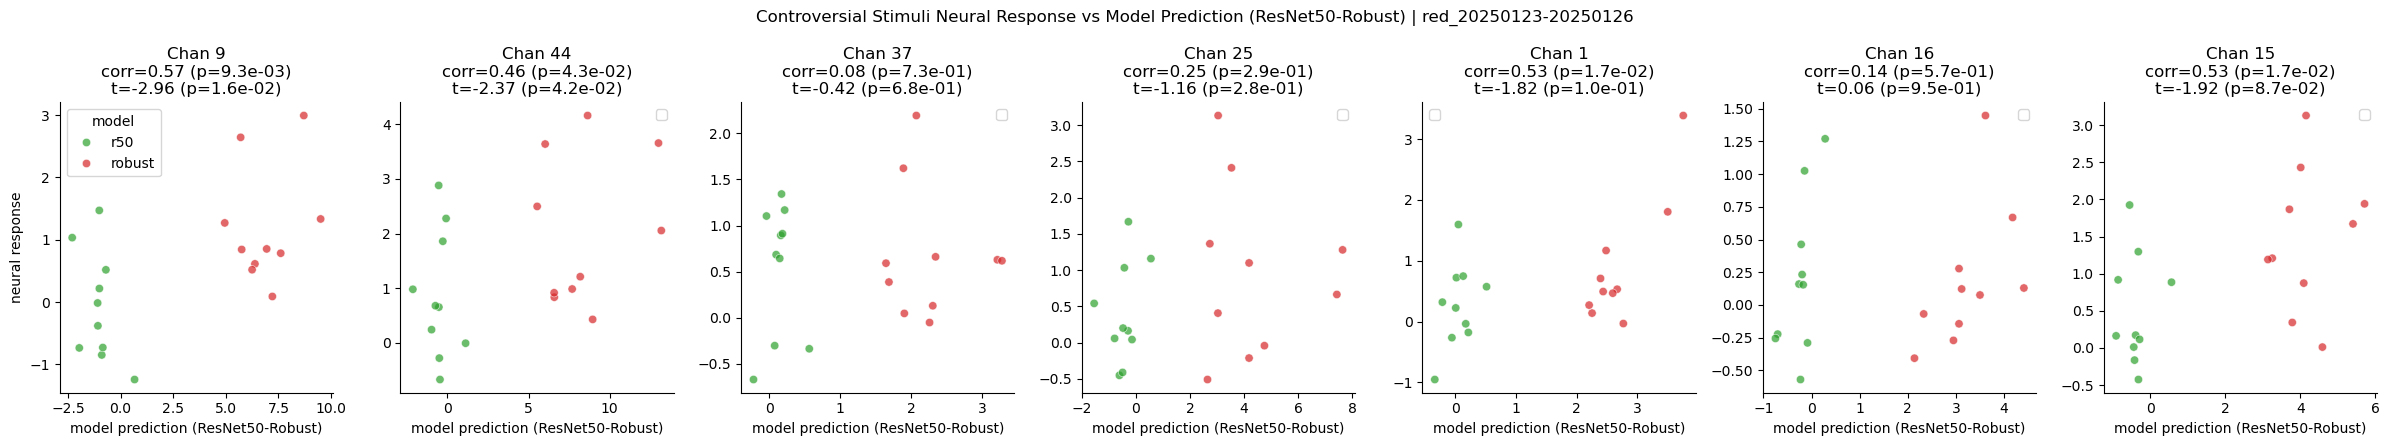

In [133]:
stim_contrv_meta_df_only = stim_contrv_meta_df.query("is_controversial")
figh, axs = plt.subplots(1, 7, figsize=(24,4.5))
for i, target_unit in enumerate(reversed(stim_contrv_meta_df_only.unit.unique())):
    plt.sca(axs[i])
    part_df = stim_contrv_meta_df_only.query("unit==@target_unit")
    # part_df = stim_contrv_meta_df_only.query("model=='r50' and unit==@target_unit")
    sns.scatterplot(data=part_df, 
                    x="score_robust", y="target_unit_resp", hue_order=["r50", "robust"], 
                    alpha=0.7, hue="model", ax=axs[i], palette=["C2", "C3"]) 
    corr, pval = pearsonr(part_df["score_robust"], part_df["target_unit_resp"])
    tval, t_pval = ttest_rel(part_df.query("model=='r50'")["target_unit_resp"], part_df.query("model=='robust'")["target_unit_resp"])
    plt.title(f"Chan {target_unit}\ncorr={corr:.2f} (p={pval:.1e})\nt={tval:.2f} (p={t_pval:.1e})")
    plt.xlabel("model prediction (ResNet50-Robust)")
    if i == 0:
        # plt.legend(["Max R50 - Robust", "Max Robust - R50"], loc="lower right")
        plt.ylabel("neural response")
    else:
        plt.legend([])
        plt.ylabel("")
plt.suptitle(f"Controversial Stimuli Neural Response vs Model Prediction (ResNet50-Robust) | {subject_id3}")
plt.tight_layout()
saveallforms(figoutdir, f"controversial_stimuli_neural_response_vs_model_prediction_ResNet50-Robust_{subject_id3}")

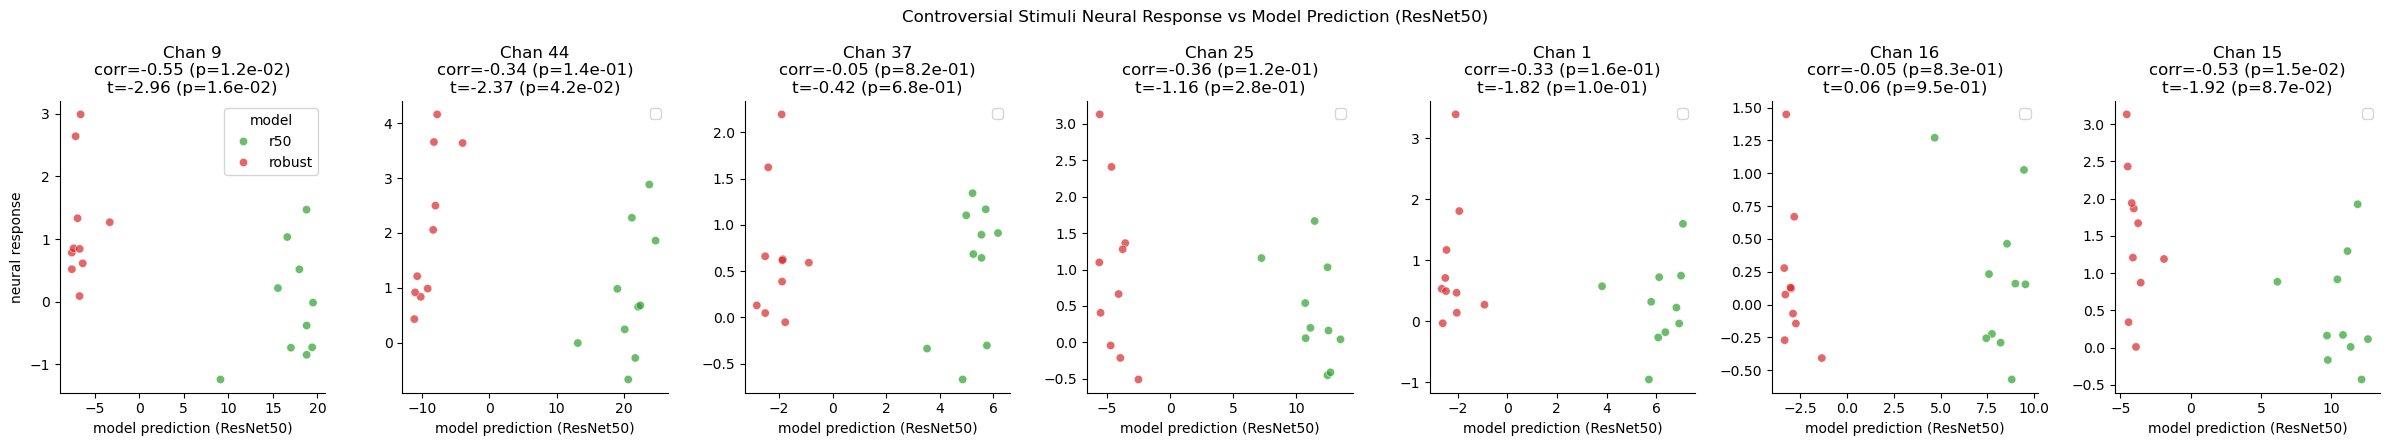

In [134]:
stim_contrv_meta_df_only = stim_contrv_meta_df.query("is_controversial")
figh, axs = plt.subplots(1, 7, figsize=(24,4.5))
for i, target_unit in enumerate(reversed(stim_contrv_meta_df_only.unit.unique())):
    plt.sca(axs[i])
    part_df = stim_contrv_meta_df_only.query("unit==@target_unit")
    sns.scatterplot(data=part_df, 
                    x="score_r50", y="target_unit_resp", hue_order=["r50", "robust"], 
                    alpha=0.7, hue="model", ax=axs[i], palette=["C2", "C3"])
    corr, pval = pearsonr(part_df["score_r50"], part_df["target_unit_resp"])
    tval, t_pval = ttest_rel(part_df.query("model=='r50'")["target_unit_resp"], part_df.query("model=='robust'")["target_unit_resp"])
    plt.title(f"Chan {target_unit}\ncorr={corr:.2f} (p={pval:.1e})\nt={tval:.2f} (p={t_pval:.1e})")
    plt.xlabel("model prediction (ResNet50)")
    if i == 0:
        # plt.legend(["Max R50 - Robust", "Max Robust - R50"], loc="lower right")
        plt.ylabel("neural response")
    else:
        plt.legend([])
        plt.ylabel("")
plt.suptitle("Controversial Stimuli Neural Response vs Model Prediction (ResNet50)")
plt.tight_layout()
saveallforms(figoutdir, f"controversial_stimuli_neural_response_vs_model_prediction_ResNet50_{subject_id3}")

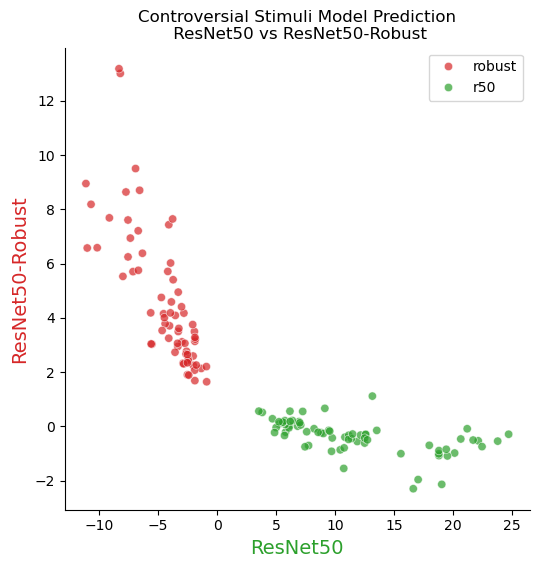

In [130]:
plt.figure(figsize=(6,6))
stim_contrv_meta_df.query("is_controversial")
sns.scatterplot(data=stim_contrv_meta_df.query("is_controversial"), x="score_r50", y="score_robust", hue="model", alpha=0.7, hue_order=["robust", "r50", ], palette=["C3", "C2"])
plt.xlabel("ResNet50", fontsize=14, color="C2")
plt.ylabel("ResNet50-Robust", fontsize=14, color="C3")
plt.title("Controversial Stimuli Model Prediction\n ResNet50 vs ResNet50-Robust")
plt.legend()
saveallforms(figoutdir, f"controversial_stimuli_model_prediction_ResNet50_vs_ResNet50-Robust_{subject_id3}")

### Controversial synopsis

In [106]:
import numpy as np
def compute_R2_per_unit(y_true, y_pred):
    ss_res = np.square(y_true - y_pred).sum(axis=0)
    ss_tot = np.square(y_true - y_true.mean(axis=0)).sum(axis=0)
    return 1 - ss_res / ss_tot

def compute_R2_per_unit_fitmean(y_true, y_pred):
    y_pred_fitmean = y_pred - y_pred.mean(axis=0) + y_true.mean(axis=0)
    ss_res = np.square(y_true - y_pred_fitmean).sum(axis=0)
    ss_tot = np.square(y_true - y_true.mean(axis=0)).sum(axis=0)
    return 1 - ss_res / ss_tot

# similar to this compute correlation coefficient per unit
def compute_corr_per_unit(y_true, y_pred):
    # If the inputs are 1D, compute a single correlation value
    if y_true.ndim == 1 and y_pred.ndim == 1:
        return np.corrcoef(y_true, y_pred)[0, 1]
    # If the inputs are 2D, compute a correlation value per unit
    n_units = y_true.shape[1]
    correlations = np.empty(n_units)
    for i in range(n_units):
        # np.corrcoef returns a 2x2 correlation matrix; [0, 1] is the correlation between the two arrays.
        correlations[i] = np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
    return correlations

In [114]:
np.repeat(unit_list, 2)

array([15, 15, 16, 16,  1,  1, 25, 25, 37, 37, 44, 44,  9,  9])

/tmp/ipykernel_4066908/2707257734.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Model', y='Correlation', data=corr_df, errorbar='se', alpha=0.7, palette=["C3", "C2"])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


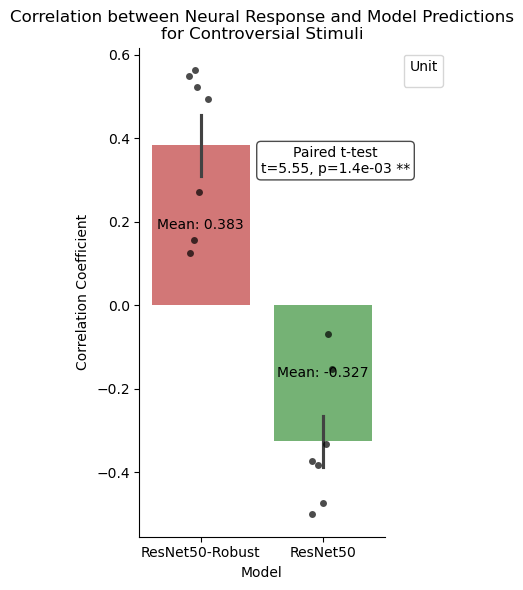

In [125]:
x_var = "RN50rbst_Lasso"
y_var = "neural_response"
target_unit = 44
corr_rbst_col = []
corr_r50_col = []
unit_list = []
for target_unit in stim_contrv_meta_df.unit.unique():
    if pd.isna(target_unit):
        continue
    img_idx = stim_contrv_meta_df.query("is_controversial and unit==@target_unit").index
    corr_rbst = compute_corr_per_unit(ds3["RN50rbst_Lasso"][img_idx, target_unit], ds3["neural_response"][img_idx, target_unit])
    corr_rn50 = compute_corr_per_unit(ds3["RN50_Lasso"][img_idx, target_unit], ds3["neural_response"][img_idx, target_unit])
    corr_rbst_col.append(corr_rbst)
    corr_r50_col.append(corr_rn50)
    unit_list.append(target_unit)

# Create a DataFrame for plotting
corr_df = pd.DataFrame({
    'Unit': np.repeat(unit_list, 2),
    'Model': ['ResNet50-Robust', ]* len(unit_list) + ['ResNet50'] * len(unit_list),
    'Correlation': corr_rbst_col + corr_r50_col
})

# Create the bar plot with strip plot overlay
plt.figure(figsize=(4, 6))
ax = sns.barplot(x='Model', y='Correlation', data=corr_df, errorbar='se', alpha=0.7, palette=["C3", "C2"])
sns.stripplot(x='Model', y='Correlation', data=corr_df, dodge=True, jitter=True, alpha=0.7, c="black")  # hue='Unit', 

# Add mean values as text on bars
for i, model in enumerate(['ResNet50-Robust', 'ResNet50']):
    mean_val = corr_df[corr_df['Model'] == model]['Correlation'].mean()
    ax.text(i, mean_val/2, f'Mean: {mean_val:.3f}', ha='center', va='center')
# paired ttest between the two and show if it's significant 
from scipy import stats
# Extract correlation values for each model
robust_corrs = np.array(corr_rbst_col)
resnet_corrs = np.array(corr_r50_col)
# Perform paired t-test
t_stat, p_value = stats.ttest_rel(robust_corrs, resnet_corrs)
# Add significance annotation to the plot
significance_text = f"Paired t-test\nt={t_stat:.2f}, p={p_value:.1e}"
if p_value < 0.05:
    significance_text += " *"
if p_value < 0.01:
    significance_text += "*"
if p_value < 0.001:
    significance_text += "*"
plt.annotate(significance_text, xy=(0.8, 0.8), xycoords='axes fraction', 
             ha='center', va='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.title('Correlation between Neural Response and Model Predictions\nfor Controversial Stimuli')
plt.ylabel('Correlation Coefficient')
plt.legend(title='Unit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
saveallforms(figoutdir, "controversial_stimuli_corr_robust_vs_resnet50_synopsis")

In [112]:
robust_corrs

array([0.49266396, 0.1569725 , 0.54941805, 0.26991277, 0.12552995,
       0.52324886, 0.56313604])

In [113]:
resnet_corrs

array([-0.47534133, -0.15216127, -0.33351051, -0.38411254, -0.06820045,
       -0.3727222 , -0.50175487])

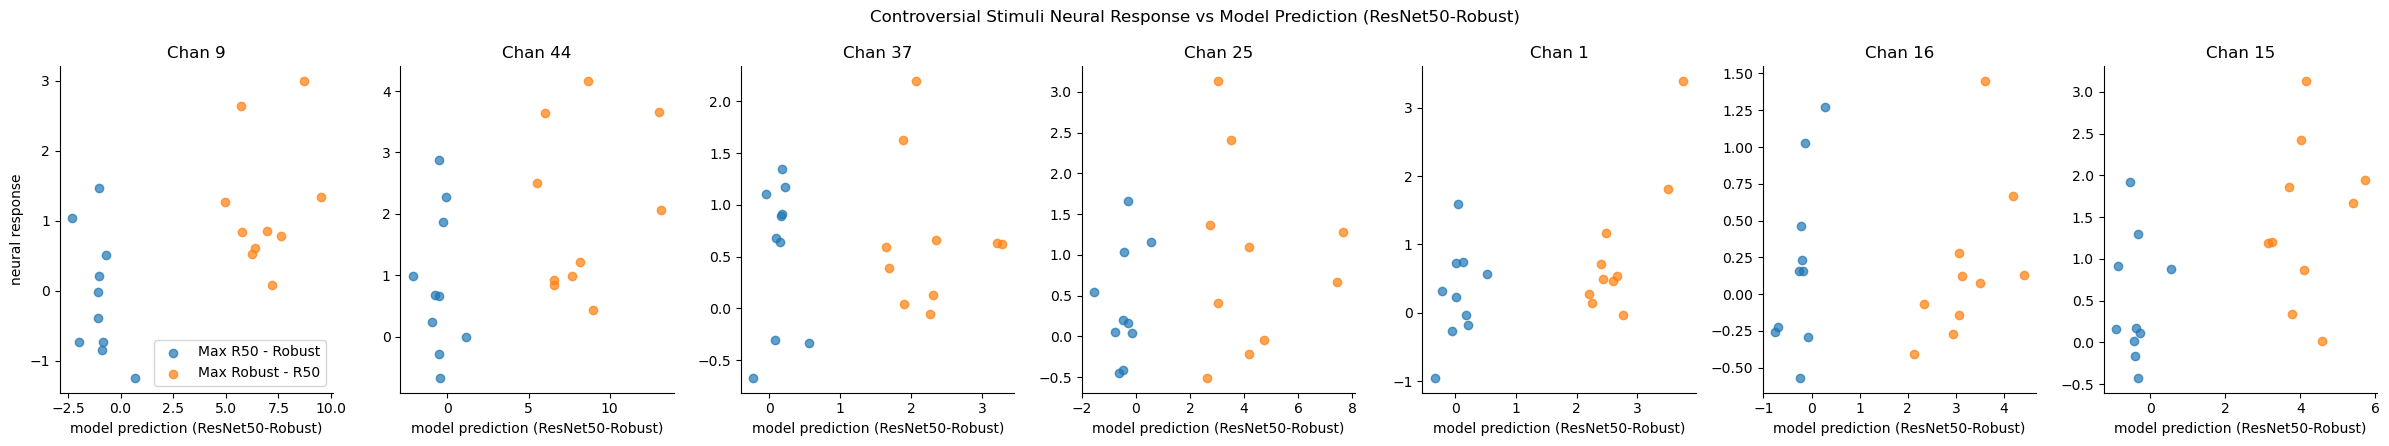

In [ ]:
stim_contrv_meta_df_only = stim_contrv_meta_df.query("is_controversial")
figh, axs = plt.subplots(1, 7, figsize=(24,4.5))
for i, target_unit in enumerate(reversed(stim_contrv_meta_df_only.unit.unique())):
    plt.sca(axs[i])
    part_df = stim_contrv_meta_df_only.query("model=='r50' and unit==@target_unit")
    plt.scatter(part_df["score_robust"], ds3.neural_response[part_df.index, target_unit],label="Max R50 - Robust", alpha=0.7)
    part_df = stim_contrv_meta_df_only.query("model=='robust' and unit==@target_unit")
    plt.scatter(part_df["score_robust"], ds3.neural_response[part_df.index, target_unit],label="Max Robust - R50", alpha=0.7)
    plt.title(f"Chan {target_unit}")
    plt.xlabel("model prediction (ResNet50-Robust)")
    if i == 0:
        plt.legend(loc="lower right")
        plt.ylabel("neural response")
    else:
        plt.ylabel("")
plt.suptitle("Controversial Stimuli Neural Response vs Model Prediction (ResNet50-Robust)")
plt.tight_layout()

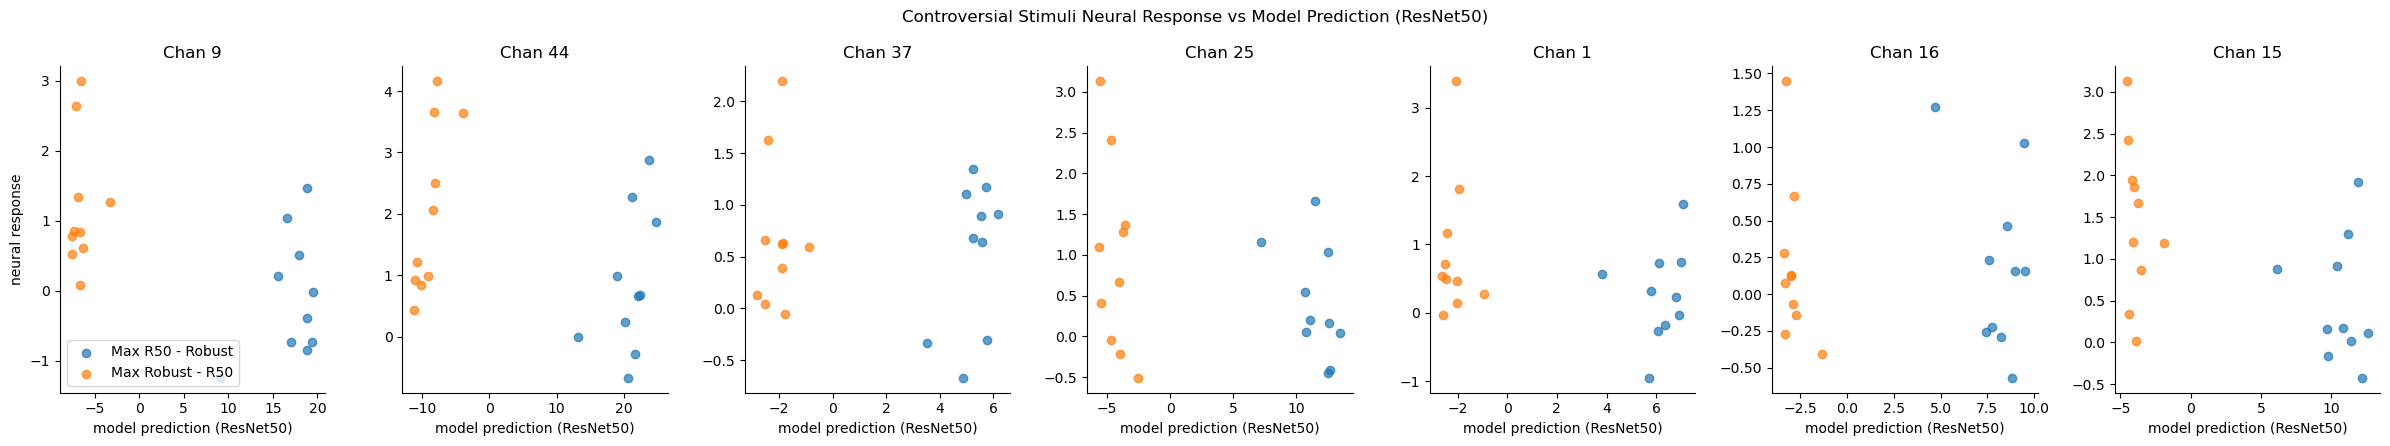

In [ ]:
stim_contrv_meta_df_only = stim_contrv_meta_df.query("is_controversial")
figh, axs = plt.subplots(1, 7, figsize=(24,4.5))
for i, target_unit in enumerate(reversed(stim_contrv_meta_df_only.unit.unique())):
    plt.sca(axs[i])
    part_df = stim_contrv_meta_df_only.query("model=='r50' and unit==@target_unit")
    plt.scatter(part_df["score_r50"], ds3.neural_response[part_df.index, target_unit], label="Max R50 - Robust", alpha=0.7)
    part_df = stim_contrv_meta_df_only.query("model=='robust' and unit==@target_unit")
    plt.scatter(part_df["score_r50"], ds3.neural_response[part_df.index, target_unit], label="Max Robust - R50", alpha=0.7)
    plt.title(f"Chan {target_unit}")
    plt.xlabel("model prediction (ResNet50)")
    if i == 0:
        plt.legend(loc="lower left")
        plt.ylabel("neural response")
    else:
        plt.ylabel("")
        
plt.suptitle("Controversial Stimuli Neural Response vs Model Prediction (ResNet50)")
plt.tight_layout()

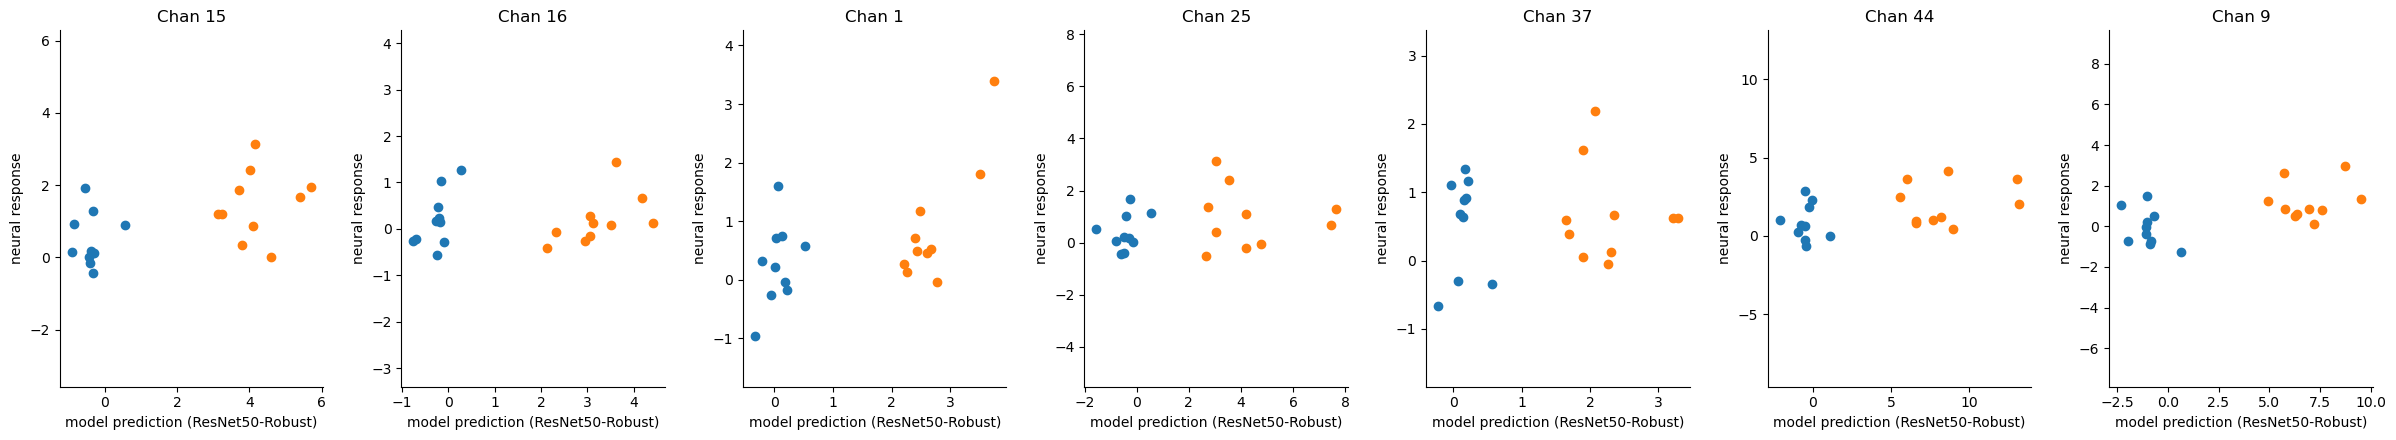

In [ ]:
stim_contrv_meta_df_only = stim_contrv_meta_df.query("is_controversial")
figh, axs = plt.subplots(1, 7, figsize=(24,4.5))
for i, target_unit in enumerate(stim_contrv_meta_df_only.unit.unique()):
    plt.sca(axs[i])
    part_df = stim_contrv_meta_df_only.query("model=='r50' and unit==@target_unit")
    plt.scatter(part_df["score_robust"], ds3.neural_response[part_df.index, target_unit],)
    part_df = stim_contrv_meta_df_only.query("model=='robust' and unit==@target_unit")
    plt.scatter(part_df["score_robust"], ds3.neural_response[part_df.index, target_unit],)
    plt.axis("equal")
    plt.title(f"Chan {target_unit}")
    plt.ylabel("neural response")
    plt.xlabel("model prediction (ResNet50-Robust)")
plt.tight_layout()
# ds3.neural_response[part_df.index, target_unit]
# part_df.score_r50

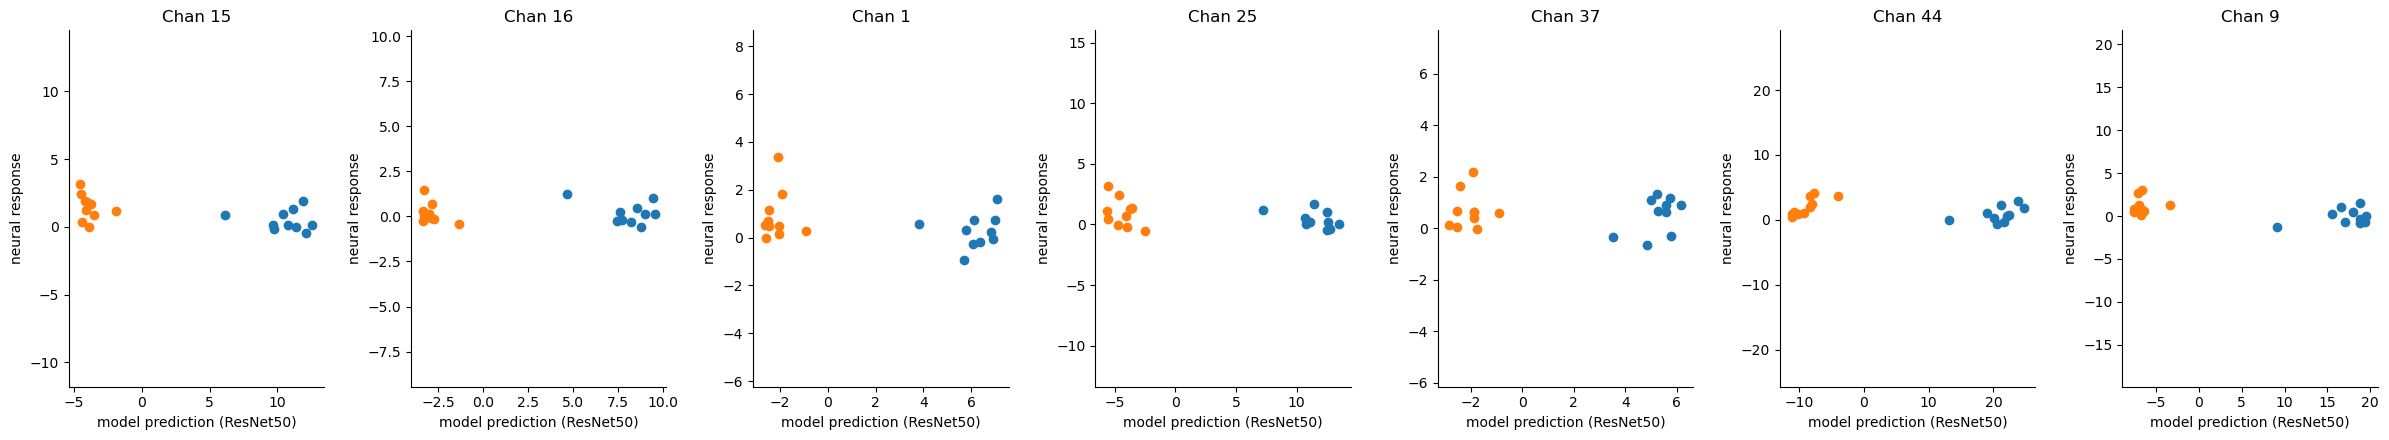

In [ ]:
# unit_id = 15
# target_unit = 15
stim_contrv_meta_df_only = stim_contrv_meta_df.query("is_controversial")
figh, axs = plt.subplots(1, 7, figsize=(24,4.5))
for i, target_unit in enumerate(stim_contrv_meta_df_only.unit.unique()):
    plt.sca(axs[i])
    part_df = stim_contrv_meta_df_only.query("model=='r50' and unit==@target_unit")
    plt.scatter(part_df["score_r50"], ds3.neural_response[part_df.index, target_unit],)
    part_df = stim_contrv_meta_df_only.query("model=='robust' and unit==@target_unit")
    plt.scatter(part_df["score_r50"], ds3.neural_response[part_df.index, target_unit],)
    plt.axis("equal")
    plt.title(f"Chan {target_unit}")
    plt.ylabel("neural response")
    plt.xlabel("model prediction (ResNet50)")
plt.tight_layout()
# ds3.neural_response[part_df.index, target_unit]
# part_df.score_r50